# Forecast of sales using ARIMA and XGBoost
# Author: Adrian Żelazek

## Table of contents

Introduction
1. Libraries
2. Dataset
3. Data Engineering
>3.1 Enumerative variables<br>
>3.2 Data types<br>
>3.3 Duplicates<br>
>3.4 Missing values<br>
>3.5 Outliers - Boxplot, Isolation Forest<br>
>Boxplot<br>
>Isolation Forest<br>
4. Exploratory Data Analysis (EDA)
>4.1 Distribution of target<br>
>4.2 Time Series Analysis<br>
>4.3 Visualization of Time Series - seasonality<br>
>4.4 Visualization of Time Series - trend<br>
5. Dummy coding
6. CORR- Correlation - Pearson / Spearman
>6.1 Correlation between target and independent variables<br>
>6.2 Correlation between independent variables<br>
7. Logarithm of target variable
8. Machine Learning Models
>8.1 ARIMA<br>
>>8.1.1 Train / Test split<br>
>>8.1.2 ACF and PACF plots<br>
>>8.1.3 Checking stationary of Series<br>
>>8.1.4 Tunning of hiper parameters by loop<br>
>>8.1.5 Tunning of hiper parameters by auto_arima<br>
>>8.1.6 Loop to make forecast of sales for many selected stores by ARIMA<br>
>>8.1.7 Function for business user to create forecast for one store by ARIMA<br>
>>8.1.8 Evaluation and visualization of forecast by ARIMA<br>
>>>8.2 XGBoost<br>
>>>>8.2.1 Loop to make forecast of sales for many selected stores by XGBoost<br>
>>>>8.2.2 Function for business user to create forecast for one store by XGBoost<br>
>>>>8.2.3 Evaluation and visualization of forecast by XGBoost<br>
9. Comparision of models
10. Conclusions

**Input (before modification) variables describtion:**
1. Id - an Id that represents a (Store, Date) duple within the test set

2. Store - a unique Id for each store

3. Sales - the turnover for any given day (this is what you are predicting)

4. Customers - the number of customers on a given day

5. Open - an indicator for whether the store was open: 0 = closed, 1 = open

6. StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

7. SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

8. StoreType - differentiates between 4 different store models: a, b, c, d

9. Assortment - describes an assortment level: a = basic, b = extra, c = extended

10. CompetitionDistance - distance in meters to the nearest competitor store

11. CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

12. Promo - indicates whether a store is running a promo on that day

13. Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

14. Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

15. PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

**Target variable:**<br>
Sales - continuous variable<br>

**Problem description:**<br>
Build, evaluate and compare models to choose the best model to create forecast of sales for stores in dataset.<br>

**Programming language:**<br>
Python<br>

**Libraries:**<br>
Scikit-learn, xgboost, statsmodels, Pandas, Numpy, Matplotlib, Seaborn<br>

**Algorithms:**<br>
Isolation Forest, Dummy coding, log, Pearson CORR, Spearman CORR, Augmented Dickey-Fuller Test, auto_arima<br>

**Models built:**<br>
ARIMA, XGBoost<br>

**Methods of model evaluation:**<br>
MAE, MAPE, MSE, RMSE, comparision of statistics on train and test datasets<br>

**WARNING!**<br>
In some Stores could be not enought observations to make good prediction, and in this case could be overfitting and if some store does not have enought observation, foracast of sales could be even impossible. In this situation is recommended to increase the number of observations for stores that have few observations. <br>

# 1. Libraries

In [401]:
#Libraries
import pandas as pd 
import numpy as np 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from pylab import rcParms
import matplotlib.patches as mpatches
from pylab import *
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import IsolationForest
from hampel import hampel
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 
import itertools
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
import pyramid as pm
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics

import xgboost as xgb
from xgboost import plot_importance
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Set style of plots
plt.style.use('ggplot')
#off science notification
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [377]:
#Version of Python and libraries used 
from platform import python_version
import matplotlib
import sklearn
print("Python version is {}".format(python_version()))
print("Pandas version is {}".format(pd.__version__))
print("Scikit-learn is {}".format(sklearn.__version__))
print("Statsmodels is {}".format(sm.__version__))
print("Numpy version is {}".format(np.__version__))
print("Matplotlib version is {}".format(matplotlib.__version__))
print("Seaborn version is {}".format(sns.__version__))
print("XGBoost version is {}".format(xgb.__version__))

Python version is 3.7.4
Pandas version is 1.1.4
Scikit-learn is 0.24.1
Statsmodels is 0.12.1
Numpy version is 1.20.1
Matplotlib version is 3.3.3
Seaborn version is 0.11.0
XGBoost version is 1.3.3


# 2. Dataset

In [402]:
#Head values and shape of set1
set1 = pd.read_csv("dataset.csv")
print("Shape of set1:", set1.shape)
set1.head(2)

Shape of set1: (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [403]:
#Head values and shape of set2
set2 = pd.read_csv("store.csv")
print("Shape of set2:", set2.shape)
set2.head(2)

Shape of set2: (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000,9.000,2008.000,0,nan,nan,NaN
1,2,a,a,570.000,11.000,2007.000,1,13.000,2010.000,"Jan,Apr,Jul,Oct"


In [404]:
#Merge of 2 data sets
data = pd.merge(set1, set2, how="left", on="Store")
data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000,9.000,2008.000,0,nan,nan,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000,11.000,2007.000,1,13.000,2010.000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.000,12.000,2006.000,1,14.000,2011.000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000,9.000,2009.000,0,nan,nan,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.000,4.000,2015.000,0,nan,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.000,6.000,2014.000,1,31.000,2013.000,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.000,4.000,2006.000,0,nan,nan,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.000,nan,nan,0,nan,nan,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.000,nan,nan,0,nan,nan,NaN


# 3. Data Engineering

## 3.1 Enumerative variables

In [405]:
#Calculating of variables based on date

#Sorting dataset by Date
data.sort_values(by="Date", ascending = True, inplace = True)
#Date columns as datetime
data["Date"] = data["Date"].astype("datetime64")

#data['Date'] = data.index
data['Hour'] = data['Date'].dt.hour
#data['Dayofweek'] = data['date'].dt.dayofweek
data['Quarter'] = data['Date'].dt.quarter
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Dayofyear'] = data['Date'].dt.dayofyear
data['Dayofmonth'] = data['Date'].dt.day
data['Weekofyear'] = data['Date'].dt.weekofyear
data['SalePerCustomer'] = data['Sales'] / data['Customers']

In [406]:
#Calculation number of days to next holiday date and since last holiday date
#Calculate date of next holiday date and last holiday date

#Holidays based on polish calendar
holidays = pd.to_datetime(["01.01.2013", "06.01.2013", "14.02.2013","29.03.2013",
                                    "31.03.2013", "01.04.2013", "01.05.2013", "03.05.2013",
                                    "19.05.2013", "26.05.2013", "30.05.2013", "23.06.2013",
                                    "15.07.2013", "27.10.2013", "01.11.2013", "11.11.2013",
                                    "24.12.2013", "25.12.2013", "26.12.2013", "31.12.2013",
                                            
                                    "01.01.2014", "06.01.2014", "14.02.2014", "30.03.2014",
                                    "18.04.2014", "20.04.2014", "21.04.2014", "01.05.2014",
                                    "03.05.2014", "03.05.2014", "26.05.2014", "08.06.2014",
                                    "19.06.2014", "23.06.2014", "15.08.2014", "26.10.2014",
                                    "01.11.2014", "11.11.2014", "24.12.2014", "25.12.2014",
                                    "26.12.2014", "31.12.2014",
                                            
                                    "01.01.2015", "06.01.2015", "14.02.2015", "29.03.2015",
                                    "03.04.2015", "05.04.2015", "06.04.2015", "01.05.2015",
                                    "03.05.2015", "24.05.2015", "26.05.2015", "04.06.2015",
                                    "23.06.2015", "15.08.2015", "25.10.2015", "01.11.2015",
                                    "11.11.2015", "24.12.2015", "25.12.2015", "26.12.2015",
                                    "31.12.2015"], dayfirst=True)

df1 = pd.DataFrame({'date1':holidays, 'date2':holidays})
df1["date1"] = df1["date1"].astype("datetime64")
df1["date2"] = df1["date2"].astype("datetime64")

data = pd.merge_asof(data, df1, left_on='Date', right_on='date1', direction='forward')
data = pd.merge_asof(data, df1, left_on='Date', right_on='date2', direction = "backward")

data["date1_x"] = data["date1_x"].astype("datetime64")
data["date1_y"] = data["date1_y"].astype("datetime64")

data["date2_x"] = data["date2_x"].astype("datetime64")
data["date2_y"] = data["date2_y"].astype("datetime64")

data['next_holiday'] = data.pop('date1_x').sub(data['Date']).dt.days.abs()
data['last_holiday'] = data['Date'].sub(data.pop('date1_y')).dt.days.abs()

data.rename(columns={"date2_x" : "next_holiday_date", "date2_y" : "last_holiday_date"},inplace=True)

In [407]:
#Setting Date as index
data.set_index("Date", inplace = True)

In [331]:
#Dataset after enumerate new varaible
data.sample(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Month,Year,Dayofyear,Dayofmonth,Weekofyear,SalePerCustomer,next_holiday_date,last_holiday_date,next_holiday,last_holiday
Date,,,,,,,,,,,,,,,,,,,,,
2013-11-12,105,2,3608,453,1,0,0,0,a,c,...,11,2013,316,12,46,7.965,2013-12-24,2013-11-11,42,1
2013-07-11,379,4,3495,429,1,0,0,1,d,a,...,7,2013,192,11,28,8.147,2013-07-15,2013-06-23,4,18
2013-08-04,633,7,0,0,0,0,0,0,d,a,...,8,2013,216,4,31,nan,2013-10-27,2013-07-15,84,20
2013-05-14,128,2,6430,511,1,1,0,0,d,c,...,5,2013,134,14,20,12.583,2013-05-19,2013-05-03,5,11
2014-02-09,109,7,0,0,0,0,0,0,a,c,...,2,2014,40,9,6,nan,2014-02-14,2014-01-06,5,34
2014-11-26,1031,3,5739,407,1,1,0,0,d,a,...,11,2014,330,26,48,14.101,2014-12-24,2014-11-11,28,15
2015-04-18,437,6,9307,1011,1,0,0,0,c,c,...,4,2015,108,18,16,9.206,2015-05-01,2015-04-06,13,12
2015-01-10,665,6,4636,749,1,0,0,0,a,a,...,1,2015,10,10,2,6.190,2015-02-14,2015-01-06,35,4
2015-07-04,191,6,7407,678,1,0,0,0,a,a,...,7,2015,185,4,27,10.925,2015-08-15,2015-06-23,42,11


## 3.2 Data types

In [332]:
#Information about types of data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2013-01-01 to 2015-07-31
Data columns (total 29 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Sales                      1017209 non-null  int64         
 3   Customers                  1017209 non-null  int64         
 4   Open                       1017209 non-null  int64         
 5   Promo                      1017209 non-null  int64         
 6   StateHoliday               1017209 non-null  object        
 7   SchoolHoliday              1017209 non-null  int64         
 8   StoreType                  1017209 non-null  object        
 9   Assortment                 1017209 non-null  object        
 10  CompetitionDistance        1014567 non-null  float64       
 11  CompetitionOpenSinceMo

In [333]:
#Lists of columns based of data type
print("Numeric variables:", data.select_dtypes(include=["int64", "float64"]).columns.tolist())
print("Categorical variables:", data.select_dtypes(include=["object"]).columns.tolist())
print("Datetime variables:", data.select_dtypes(include=["datetime64"]).columns.tolist())

Numeric variables: ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Hour', 'Quarter', 'Month', 'Year', 'Dayofyear', 'Dayofmonth', 'Weekofyear', 'SalePerCustomer', 'next_holiday', 'last_holiday']
Categorical variables: ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
Datetime variables: ['next_holiday_date', 'last_holiday_date']


## 3.3 Duplicates

In [334]:
#Search of duplicated obserwations
data[data.duplicated(data.columns.tolist(), keep=False)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Month,Year,Dayofyear,Dayofmonth,Weekofyear,SalePerCustomer,next_holiday_date,last_holiday_date,next_holiday,last_holiday
Date,,,,,,,,,,,,,,,,,,,,,


## 3.4 Missing values

In [335]:
#Detection of missing values
summary = pd.DataFrame(data.dtypes, columns=['Feature type'])
summary["Is_Null"] = pd.DataFrame(data.isnull().any())
summary["Sum_Null"] = pd.DataFrame(data.isnull().sum())
summary["Is_NaN"] = pd.DataFrame(data.isna().any())
summary["Sum_NaN"] = pd.DataFrame(data.isna().sum())
summary["Null_perc"] = round((data.apply(pd.isnull).mean()*100),2)
summary["NaN_perc"] = round((data.apply(pd.isna).mean()*100),2)
summary

,Feature type,Is_Null,Sum_Null,Is_NaN,Sum_NaN,Null_perc,NaN_perc
Store,int64,False,0,False,0,0.000,0.000
DayOfWeek,int64,False,0,False,0,0.000,0.000
Sales,int64,False,0,False,0,0.000,0.000
Customers,int64,False,0,False,0,0.000,0.000
Open,int64,False,0,False,0,0.000,0.000
Promo,int64,False,0,False,0,0.000,0.000
StateHoliday,object,False,0,False,0,0.000,0.000
SchoolHoliday,int64,False,0,False,0,0.000,0.000
StoreType,object,False,0,False,0,0.000,0.000
Assortment,object,False,0,False,0,0.000,0.000


In [336]:
#Checking of missing values in the dataset
print("Null values:",data.isnull().sum().sum())
print("NaN values:",data.isna().sum().sum())

Null values: 2346300
NaN values: 2346300


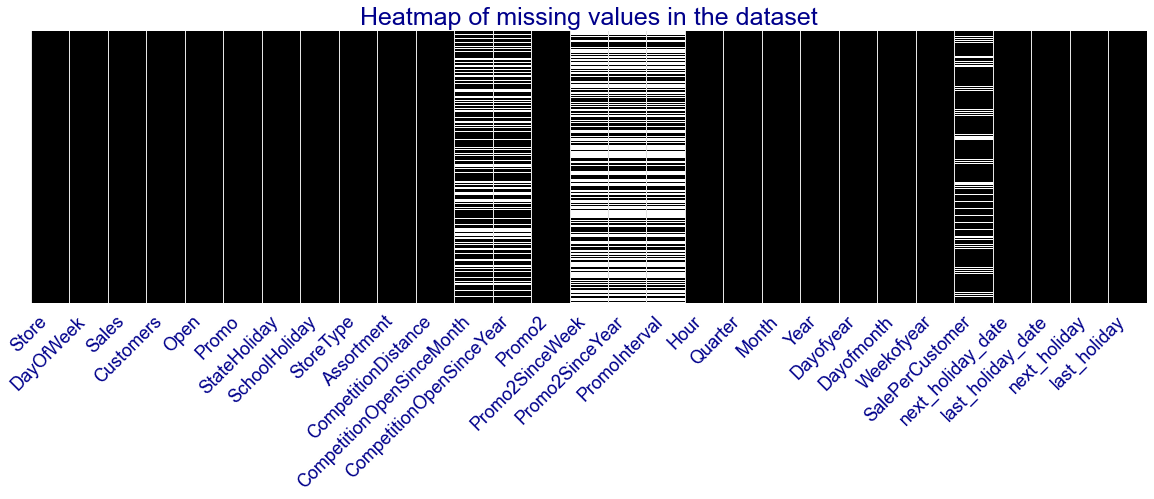

In [337]:
#Heatmap of missing values 
#Size of the plot 
plt.figure(figsize=(20,5))

#Creation of the heatmap 
sns.heatmap(data.isnull(),
            yticklabels=False,
            cbar=False, 
            cmap="bone").set_title("Heatmap of missing values in the dataset", 
                                   fontsize = 25,
                                   color = "darkblue")

#X-axis descriptions in terms of rotation and size of caption 
plt.xticks(rotation=45, fontsize=18, horizontalalignment="right", color="darkblue")
plt.ylabel("")
plt.show()

* If there is no promotion, PromotionInterval is NaN -> change to 0, the same situation in Promo2SinceYear and Promo2SinceWeek
* CompetitionOpenSinceMonth / Year - NaN means that there are no competing stores nearby or we do not have any information that some competition company will open nearby, so NaN --> change to 0 
* CompetitionDistance will be fill by median, because it it the best measure, moreover this variables has only 0.26 % of missings, so NaN --> change median
* SalePerCustomer, NaN if Sales is 0, so fill NaN by 0

In [408]:
#Work with missings
data["PromoInterval"].fillna(0, inplace = True)
data["Promo2SinceYear"].fillna(0, inplace = True)
data["Promo2SinceWeek"].fillna(0, inplace = True)
data["CompetitionOpenSinceMonth"].fillna(0, inplace = True)
data["CompetitionOpenSinceYear"].fillna(0, inplace = True)
data['CompetitionDistance'].fillna(data['CompetitionDistance'].median(), inplace = True)
data["SalePerCustomer"].fillna(0, inplace = True)

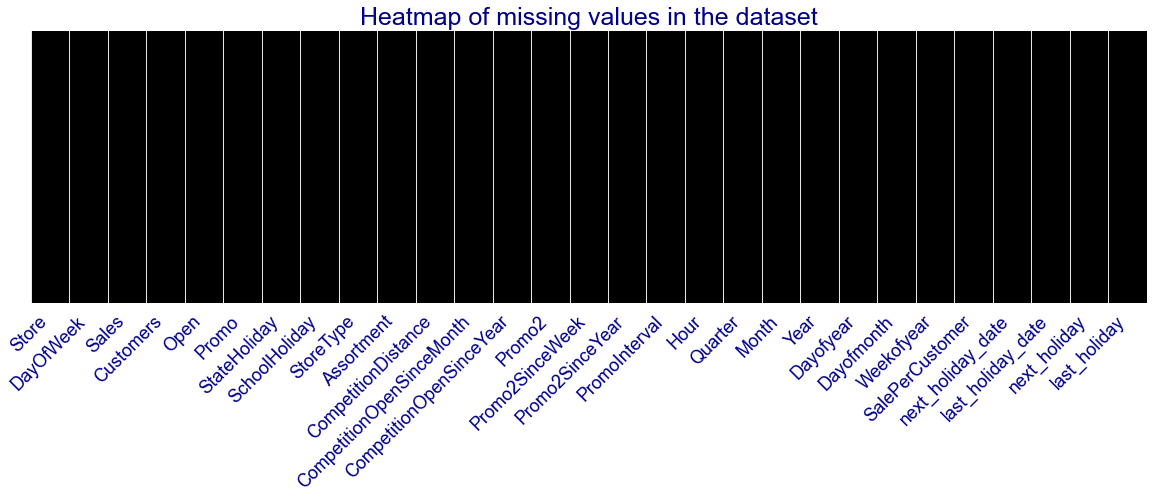

In [339]:
#Heatmap of missing values - after filling missing values
#Size of the plot 
plt.figure(figsize=(20,5))

#Creation of the heatmap 
sns.heatmap(data.isnull(),
            yticklabels=False,
            cbar=False, 
            cmap="bone").set_title("Heatmap of missing values in the dataset", 
                                   fontsize = 25,
                                   color = "darkblue")

#X-axis descriptions in terms of rotation and size of caption 
plt.xticks(rotation=45, fontsize=18, horizontalalignment="right", color="darkblue")
plt.ylabel("")
plt.show()

In [340]:
#Checking of missing values in the dataset after fil missings values
print("Null values:",data.isnull().sum().sum())
print("NaN values:",data.isna().sum().sum())

Null values: 0
NaN values: 0


## 3.5 Outliers - Boxplot, Isolation Forest

In [409]:
#Numeric columns from dataset - for boxplots
data_num_col = data.select_dtypes(include=["int64", "float64"])
#Numeric columns from dataset without target- for Isolation Forest and Hampel
num_col = [x for x in data_num_col.columns.tolist() if x != "wine_type"]

### Boxplot

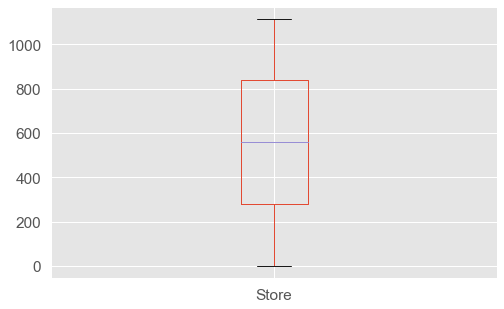

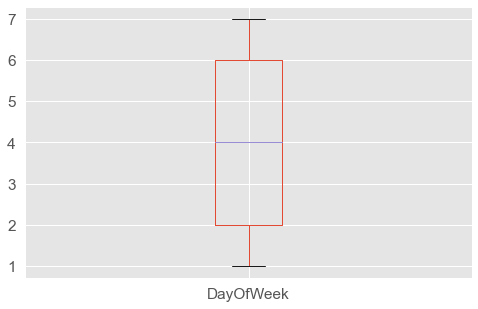

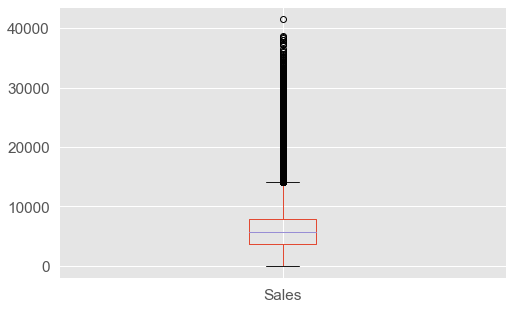

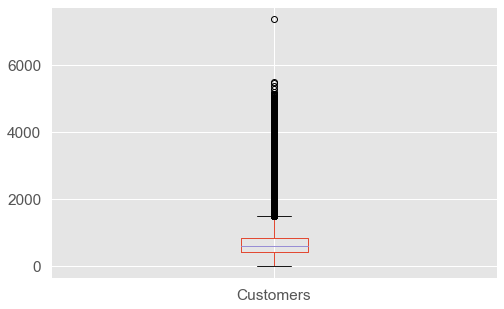

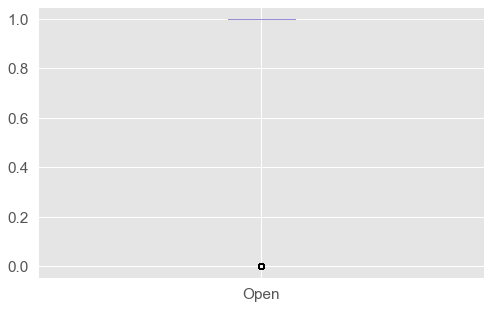

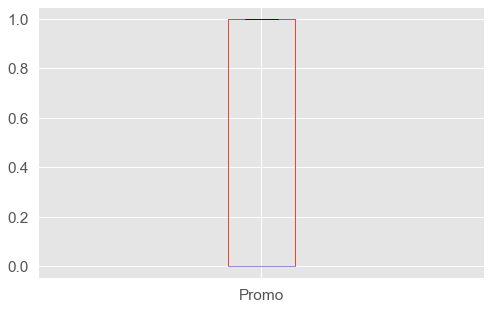

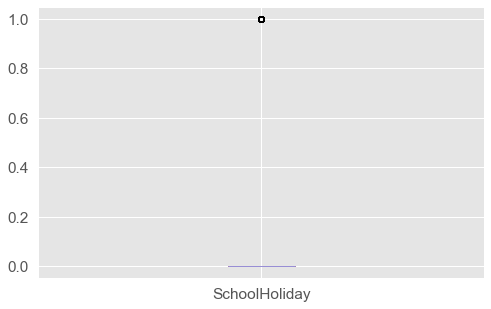

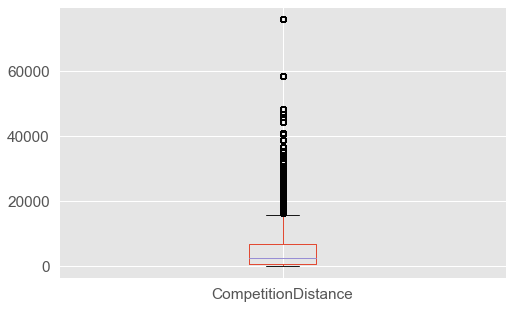

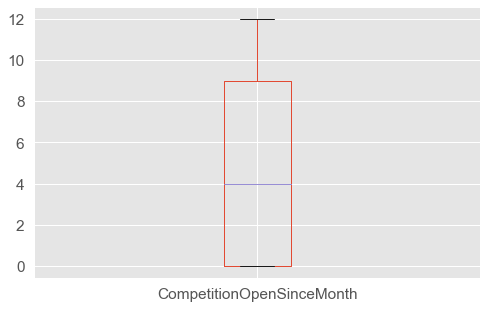

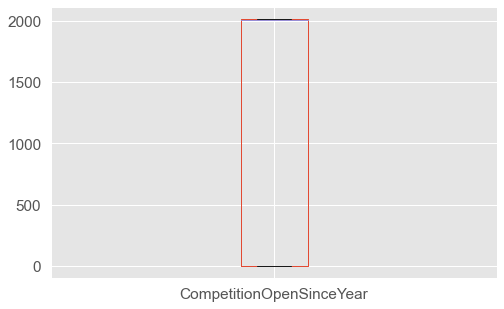

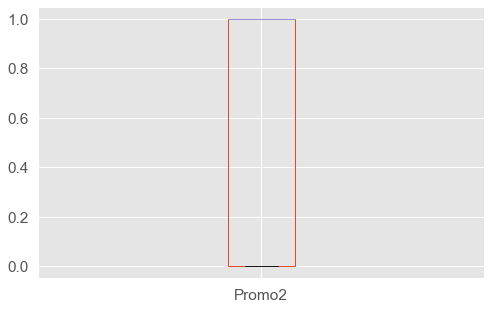

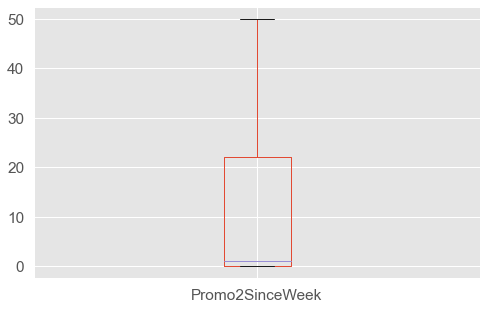

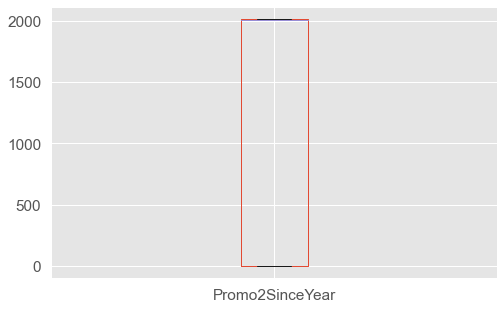

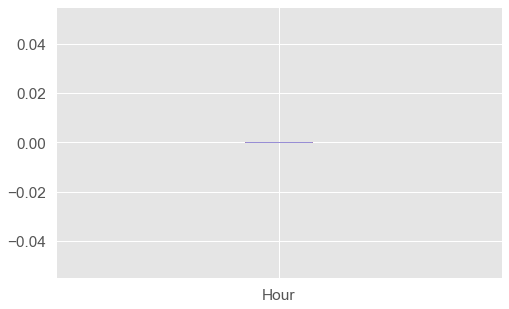

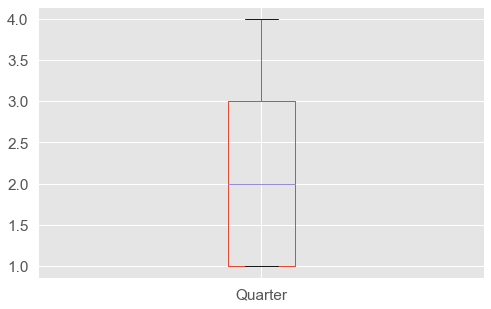

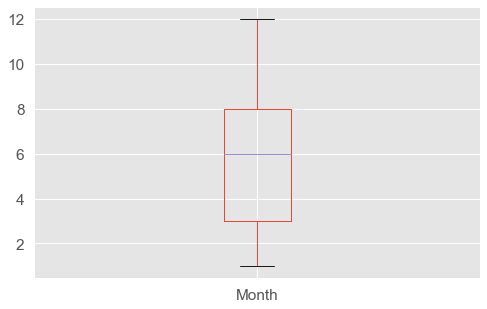

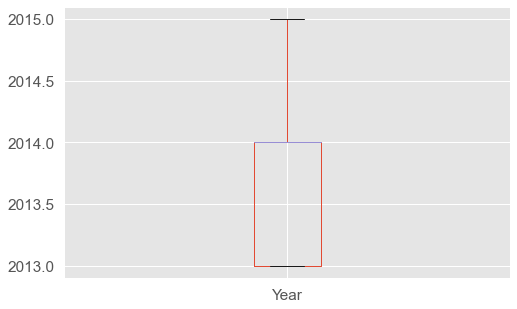

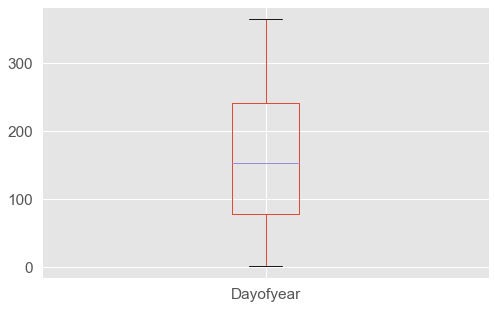

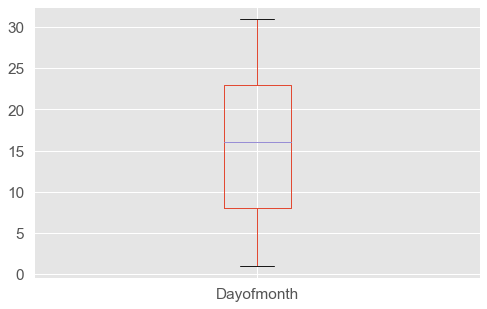

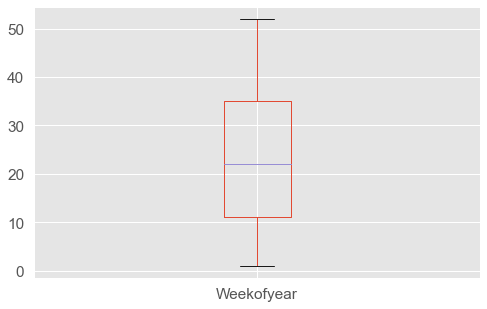

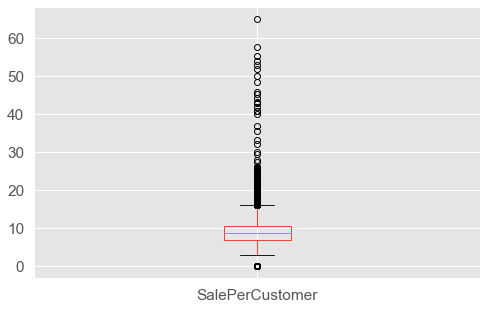

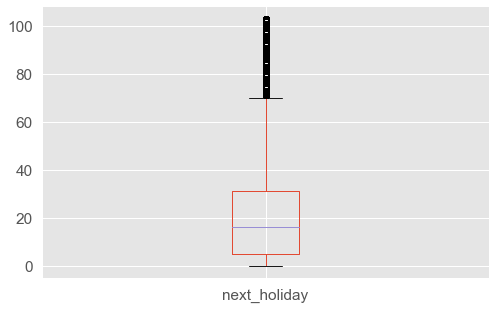

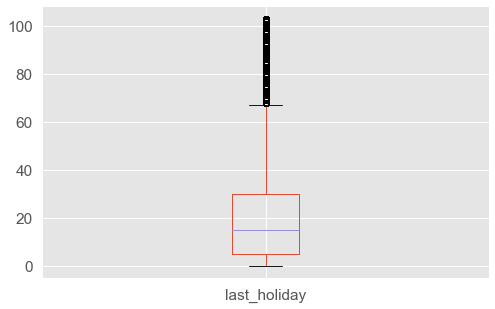

In [342]:
#Boxplots
for column in data_num_col:
    ax = plt.figure(figsize=(8,5))
    data_num_col.boxplot([column])

Based on boxplots there are outliers in: Sales, Customers, CompetitionDIstance, SalePerCustomer, next_holiday, last_holiday

In [410]:
#Isolation Forest model to find obserwations with outliers
model = IsolationForest(n_estimators=50, max_samples='auto', max_features=1.0, contamination = 0.05)
#Traning of IF model on numeric columns of dataset
model.fit(data[num_col])

#Adding score and animaly columns which show obserwations with outliers in dataset
data["scores"] = model.decision_function(data[num_col])
data["anomaly"] = model.predict(data[num_col])
data

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Dayofyear,Dayofmonth,Weekofyear,SalePerCustomer,next_holiday_date,last_holiday_date,next_holiday,last_holiday,scores,anomaly
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,d,c,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.038,-1
2013-01-01,379,2,0,0,0,0,a,1,d,a,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.028,-1
2013-01-01,378,2,0,0,0,0,a,1,a,c,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.003,-1
2013-01-01,377,2,0,0,0,0,a,1,a,c,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.016,-1
2013-01-01,376,2,0,0,0,0,a,1,a,a,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.007,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,746,5,9082,638,1,1,0,1,d,c,...,212,31,31,14.235,2015-08-15,2015-06-23,15,38,0.042,1
2015-07-31,747,5,10708,826,1,1,0,1,c,c,...,212,31,31,12.964,2015-08-15,2015-06-23,15,38,0.015,1
2015-07-31,748,5,7481,578,1,1,0,1,d,a,...,212,31,31,12.943,2015-08-15,2015-06-23,15,38,0.063,1


In [411]:
#DataFrame with outliers from dataset
outliers = data.loc[data["anomaly"]== - 1]
#Indexes of obserwations with outliers
anomaly_index = outliers.index.tolist()

In [412]:
#Observations with outliers
outliers

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Dayofyear,Dayofmonth,Weekofyear,SalePerCustomer,next_holiday_date,last_holiday_date,next_holiday,last_holiday,scores,anomaly
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,d,c,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.038,-1
2013-01-01,379,2,0,0,0,0,a,1,d,a,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.028,-1
2013-01-01,378,2,0,0,0,0,a,1,a,c,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.003,-1
2013-01-01,377,2,0,0,0,0,a,1,a,c,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.016,-1
2013-01-01,376,2,0,0,0,0,a,1,a,a,...,1,1,1,0.000,2013-01-01,2013-01-01,0,0,-0.007,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,808,5,10715,786,1,1,0,1,a,a,...,212,31,31,13.632,2015-08-15,2015-06-23,15,38,-0.009,-1
2015-07-31,817,5,23093,2884,1,1,0,1,a,a,...,212,31,31,8.007,2015-08-15,2015-06-23,15,38,-0.000,-1
2015-07-31,732,5,10919,1150,1,1,0,1,a,c,...,212,31,31,9.495,2015-08-15,2015-06-23,15,38,-0.006,-1


In [413]:
#Printing amount of observations with outliers and indexes of observations with outliers
print("Dataset has:",outliers.shape[0], "observations with outliers:", round(outliers.shape[0] / data.shape[0],4) *100, "%.")

Dataset has: 50861 observations with outliers: 5.0 %.


In [414]:
#Dropping of values with annomaly
#Execution of below line is really long, so was used second line to drop observations with anomaly
#data.drop(index = data[data["anomaly"]== -1].index, inplace = True, axis = 0)
data = data[data["anomaly"] != -1]
#Dropping unnecessairy columns for further analysis: "scores", "anomaly"
data.drop(columns=["scores", "anomaly"], inplace=True)

# 4. Explatory Data Analysis (EDA)

## 4.1 Distribution of target

Distribution of plot is not, so probably before modelling it will be good idea to logarithm this variable to increase effectiveness of models.

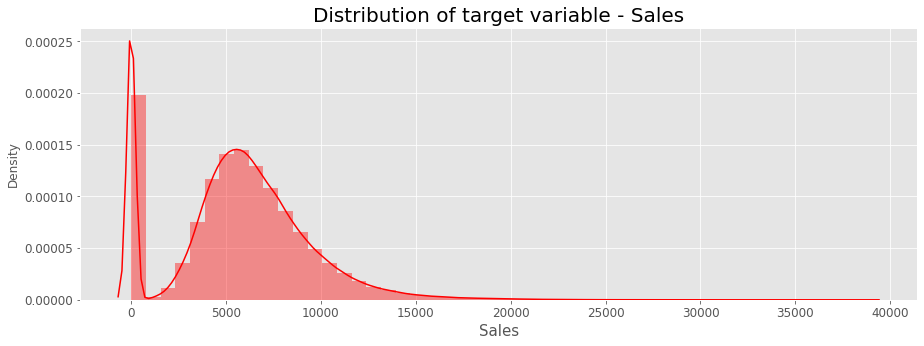

In [27]:
#Plot presents distribution of target variable
rcParams["figure.figsize"] = 15, 5 
sns.distplot(data["Sales"], color="red")
plt.title("Distribution of target variable - Sales", fontsize= 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sales",fontsize=15)
plt.show()

## 4.2 Time Series analysis

Breakdown of sales by store type.

In [28]:
data.groupby("StoreType")["Sales"].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,524741.000,5711.290,3708.278,0.000,3657.000,5638.000,7779.000,34001.000
b,12969.000,9043.670,4699.396,0.000,5835.000,8114.000,11403.000,38722.000
c,131708.000,5757.674,3569.114,0.000,3927.000,5801.000,7820.000,30143.000
d,296930.000,5699.807,3299.848,0.000,4151.000,5866.000,7669.000,38037.000


In [29]:
data.groupby("StoreType")["Customers", "Sales"].sum()

,Customers,Sales
StoreType,,
a,344432310,2996948216
b,23327783,117287353
c,89431582,758331697
d,151331028,1692443589


Store Type b presents definitely the highest sales both during and without promotion. Without promotion the best sales is about May and during promotion the best sales is on June and December. Rest of Store Type presents similar trend, where during promotion sales is around two times better than without. Peak is also around December, which is understandable and caused by Christmas.

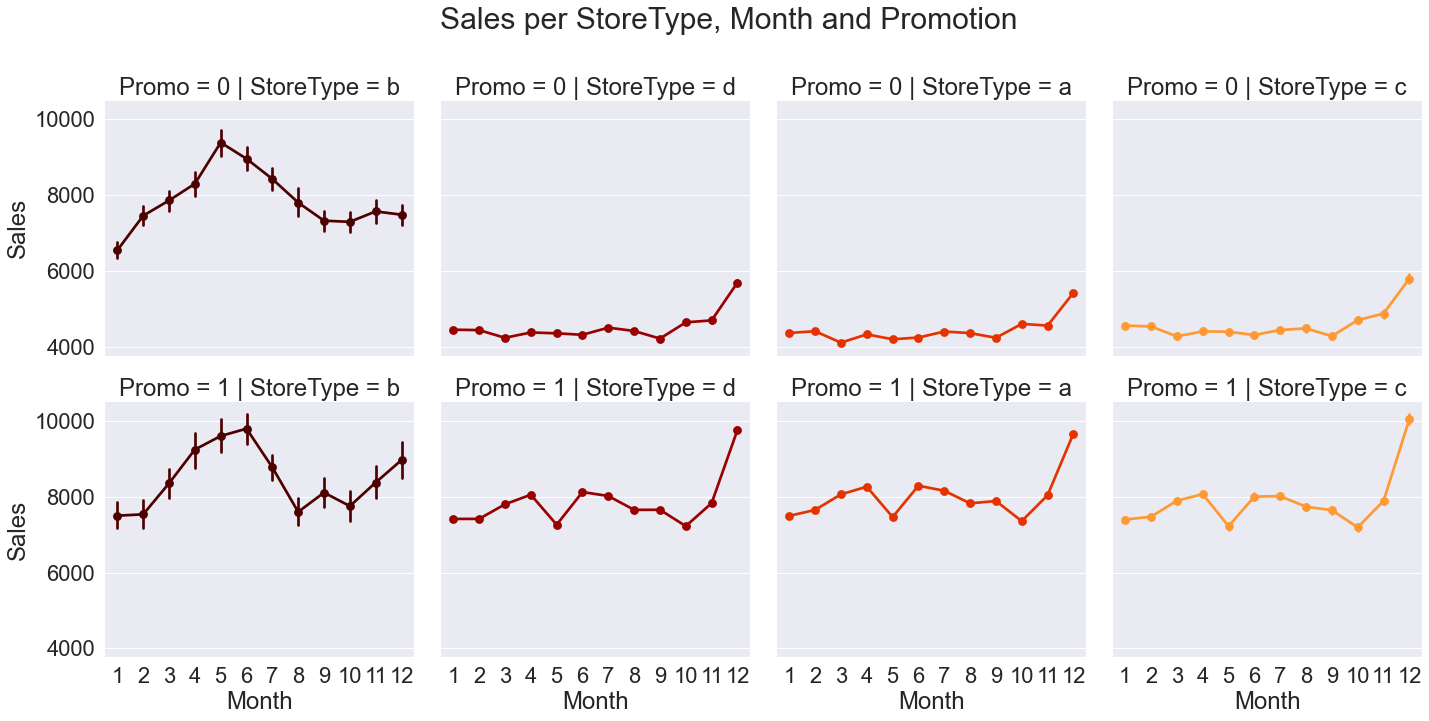

In [122]:
#Factorplot to show in which Store Type is the best sales per month and considering promotions
sns.set(font_scale=2)
x = sns.factorplot(data = data,
               x = "Month",
               y = "Sales", 
               col = "StoreType", 
               palette = "gist_heat",
               hue = "StoreType",
               row = "Promo")
x.fig.subplots_adjust(top=0.85)
x.fig.suptitle("Sales per StoreType, Month and Promotion", fontsize = 30)
plt.savefig("EDA_plots/Sales_per_StoreType_Month_Promo.png", bbox_inches = "tight")
plt.show()

As in the case of sales, in terms of the number of customers Store Type b also generate the best results. Rest of Store Types generate similar numbers.

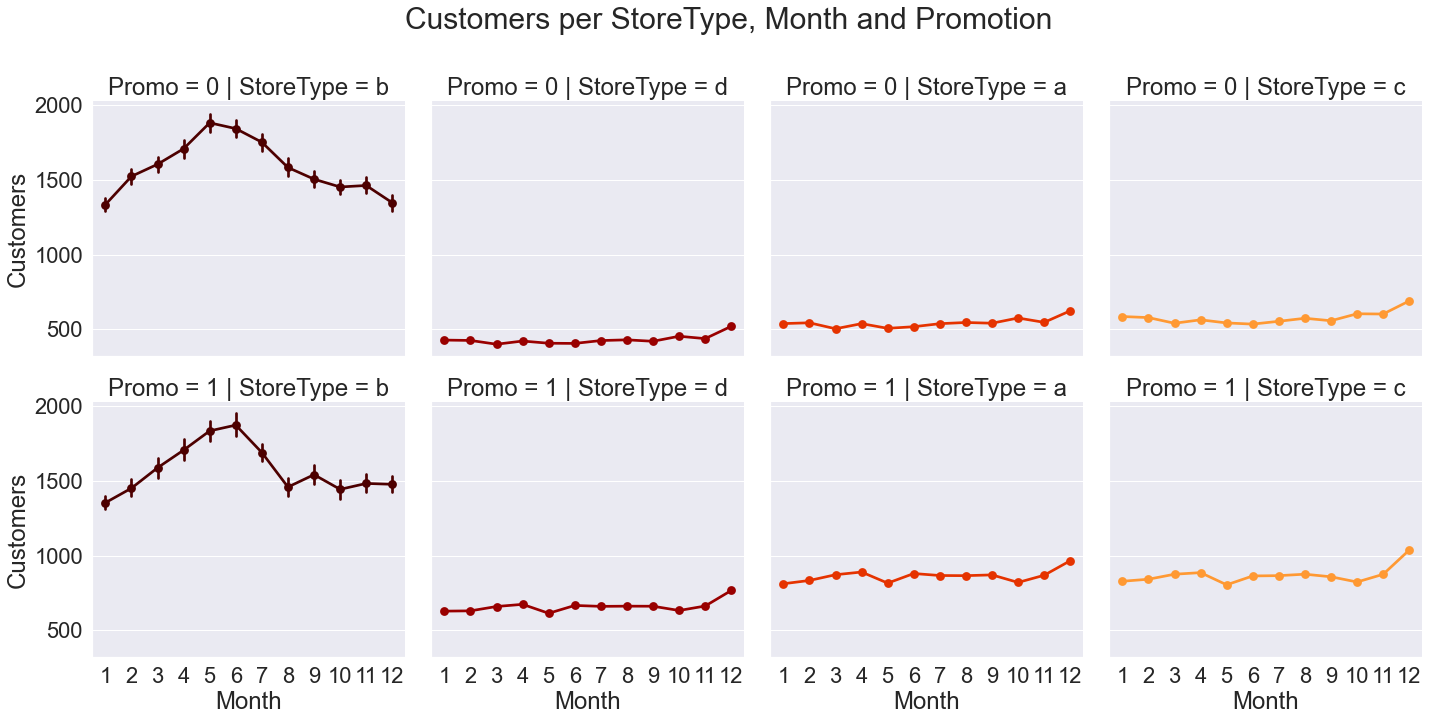

In [123]:
#Factorplot to show in which Store Type is the highest number of customers per month and considering promotions
sns.set(font_scale=2)
y = sns.factorplot(data = data,
               x = "Month",
               y = "Customers", 
               col = "StoreType", 
               palette = "gist_heat",
               hue = "StoreType",
               row = "Promo")
y.fig.subplots_adjust(top=0.85)
y.fig.suptitle("Customers per StoreType, Month and Promotion", fontsize = 30)
plt.savefig("EDA_plots/Customers_StoreType_Month_Promo.png", bbox_inches = "tight")
plt.show()

Considering the number of sales per customer Store Type b does not generate high numbers. In this condition there is significant advantage of Store Type d, mainly during promotion time. 

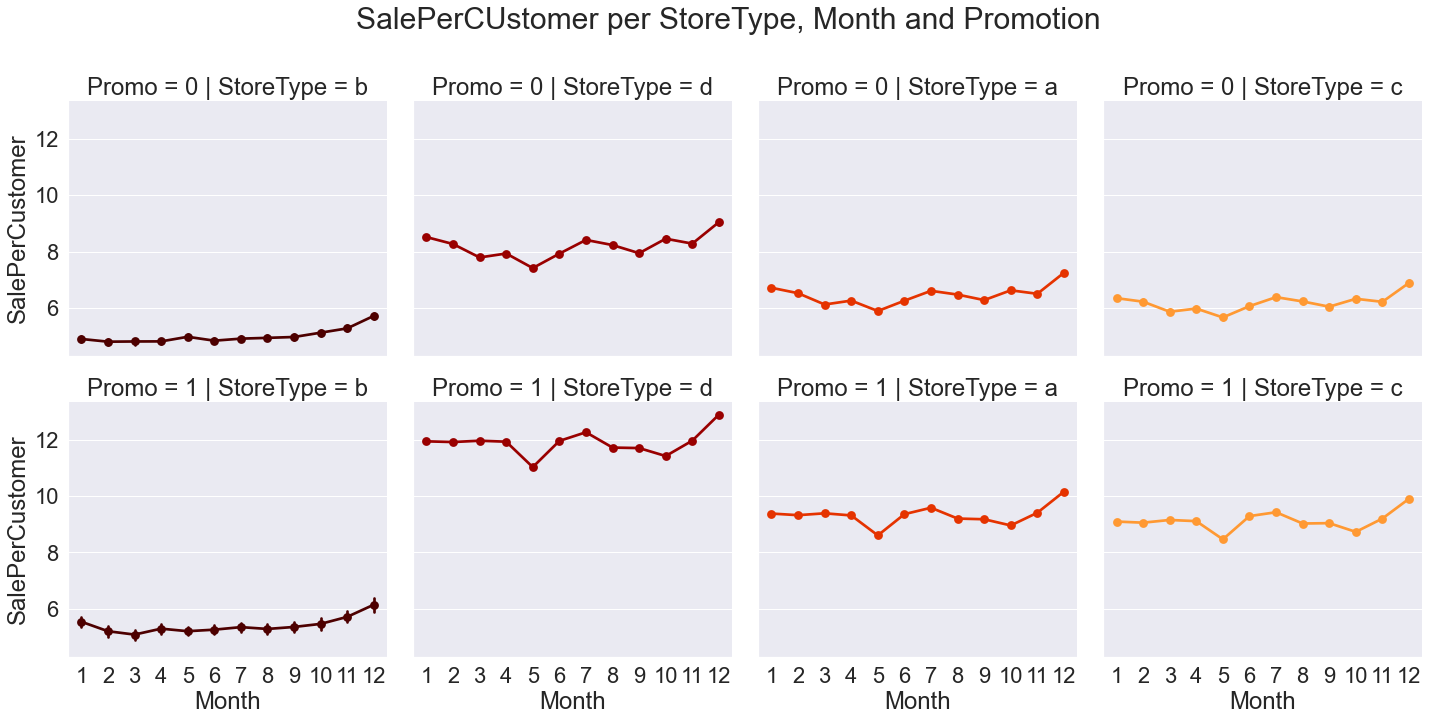

In [124]:
#Factorplot to show in which Store Type is the best sales considering sale per customer, month and promotion
sns.set(font_scale=2)
z = sns.factorplot(data = data,
               x = "Month",
               y = "SalePerCustomer", 
               col = "StoreType", 
               palette = "gist_heat",
               hue = "StoreType",
               row = "Promo") 
z.fig.subplots_adjust(top=0.85)
z.fig.suptitle("SalePerCUstomer per StoreType, Month and Promotion", fontsize = 30)
plt.savefig("EDA_plots/SalePerCUstomer_StoreType_Month_Promo.png", bbox_inches = "tight")
plt.show()

Only stores from Store Type b are open on sunday, which may be partly the reason for the store types's high sales figures. In each Store Type sales are steady all week, but drop slightly on Saturday.

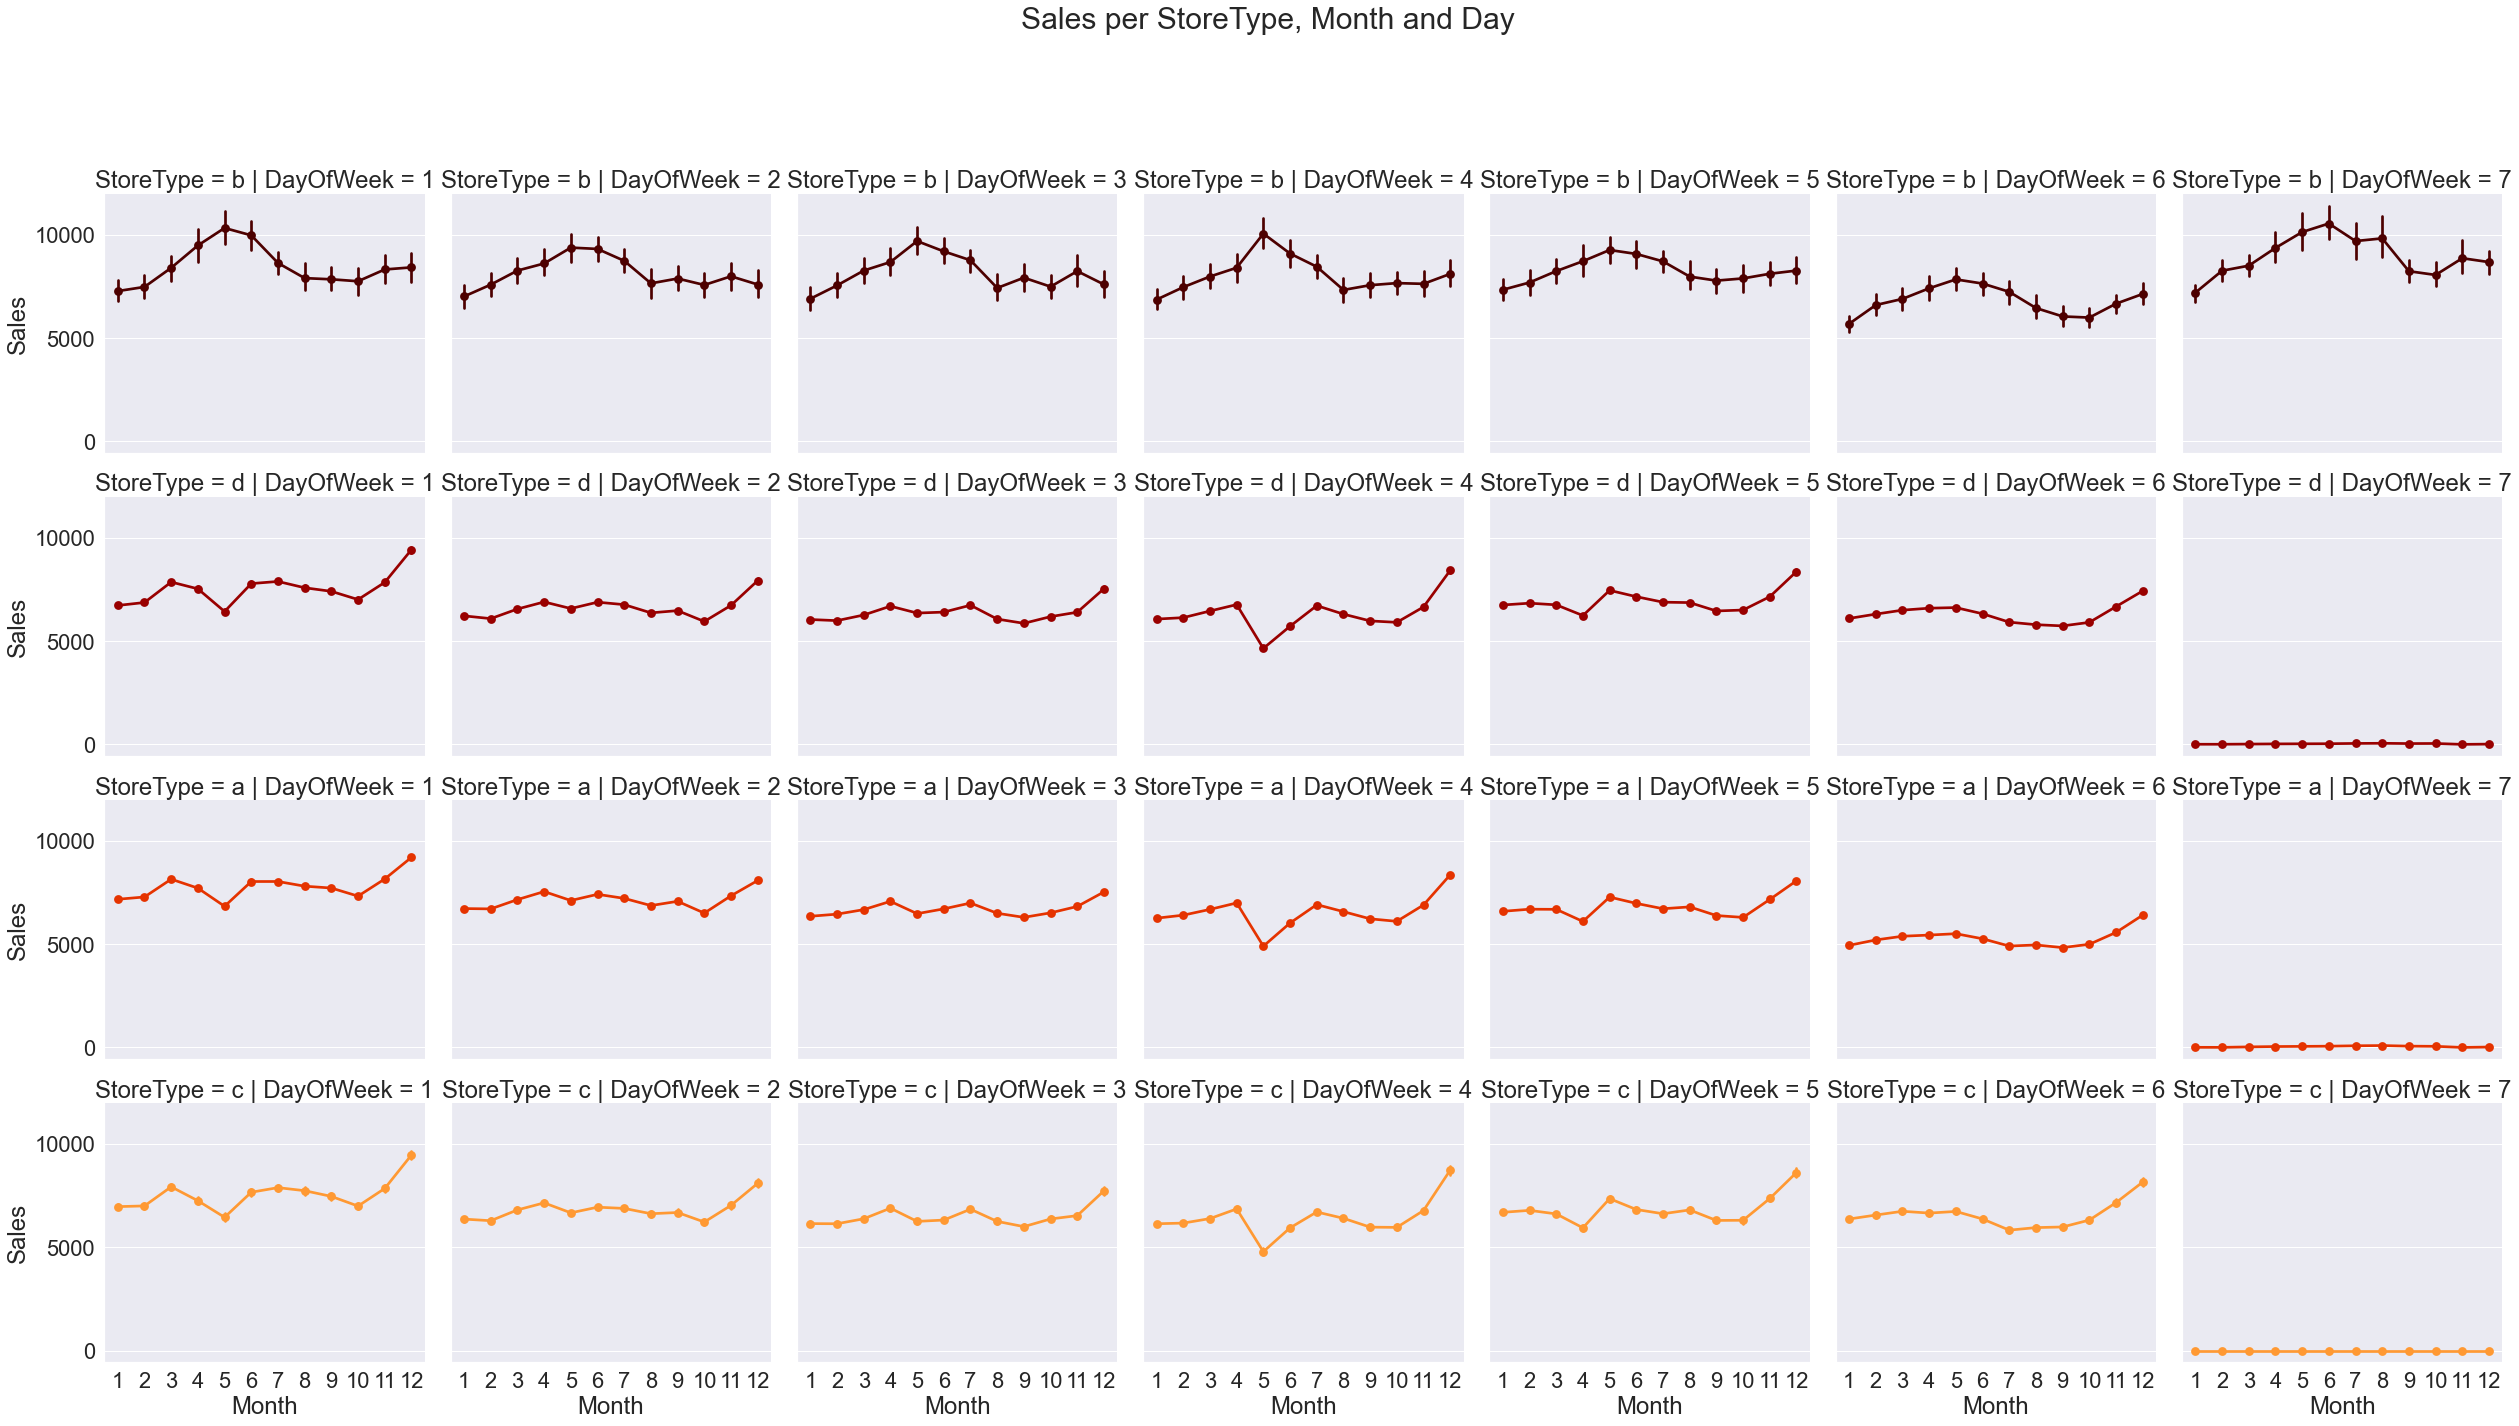

In [125]:
#Factor plot to show level of sales in each day in each month
sns.set(font_scale=2)
zz = sns.factorplot(data = data,
               x = "Month",
               y = "Sales", 
               col = "DayOfWeek",
               palette = "gist_heat",
               hue = "StoreType",
               row = "StoreType") 
zz.fig.subplots_adjust(top=0.85)
zz.fig.suptitle("Sales per StoreType, Month and Day", fontsize = 30)
plt.savefig("EDA_plots/Sales_StoreType_Month_Day.png", bbox_inches = "tight")
plt.show()

## 4.3 Visualization of Time Series - Seasonality

Data was downsample from days to weeks using the resample method to see the present trends more clearly.

In [74]:
def seasonality(store_number, color, store_type):
    """
    Function to plot seasonality of Sales in selected Store. Data was downsample from days
    to weeks using the resample method to see the present trends more clearly.
    Input: 
    store_number: number of selected Store
    color: color of plot
    store_type: type of store (a, b, c, d)
    """
    rcParams["figure.figsize"] = 15, 5
    data['Sales'] = data['Sales'] * 1.0

    # store types
    sales_a = data[data.Store == store_number]['Sales']

    # store types
    sales_a.resample('W').sum().plot(color = color, fontsize = 10)
    plt.title("Store " + str(store_number) + " store type " + str(store_type), fontsize= 15)
    plt.xlabel("Date", fontsize= 15)

    plt.tight_layout()
    plt.show()

In [66]:
#Unique types of Stores
print(data["StoreType"].unique())
print(data["StoreType"].value_counts())

['b' 'd' 'a' 'c']
a    524741
d    296930
c    131708
b     12969
Name: StoreType, dtype: int64


Firstly, the most common Stores for each Store Type were selected.

In [67]:
#The most common type a stores
store_type_a = data[data["StoreType"]=="a"]

store_count_a = store_type_a.groupby("Store").agg(count_a = ("Store", "count"))
store_count_a.sort_values(by="count_a", ascending = False, inplace = True)
store_count_a.head(3)

,count_a
Store,
222,933
134,933
240,933


In [68]:
#The most common type b stores
store_type_b = data[data["StoreType"]=="b"]

store_count_b = store_type_b.groupby("Store").agg(count_b = ("Store", "count"))
store_count_b.sort_values(by="count_b", ascending = False, inplace = True)
store_count_b.head(3)

,count_b
Store,
494,940
85,939
1081,908


In [69]:
#The most common type c stores
store_type_c = data[data["StoreType"]=="c"]

store_count_c = store_type_c.groupby("Store").agg(count_c = ("Store", "count"))
store_count_c.sort_values(by="count_c", ascending = False, inplace = True)
store_count_c.head(3)

,count_c
Store,
472,934
596,933
131,933


In [70]:
#The most common type d stores
store_type_d = data[data["StoreType"]=="d"]

store_count_d = store_type_d.groupby("Store").agg(count_d = ("Store", "count"))
store_count_d.sort_values(by="count_d", ascending = False, inplace = True)
store_count_d.head(3)

,count_d
Store,
478,932
496,932
556,932


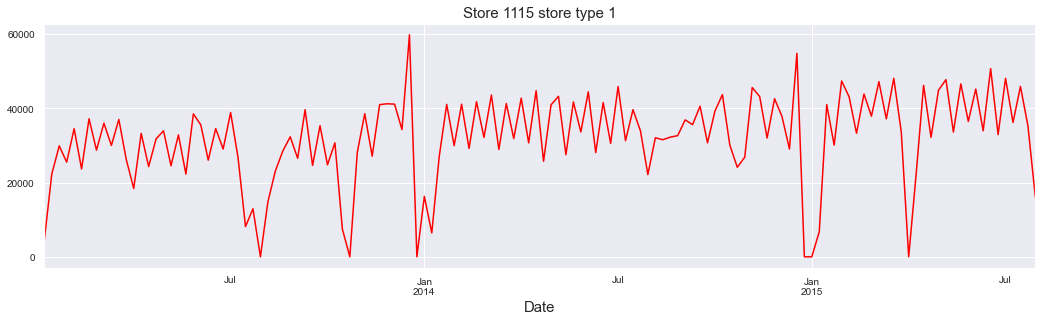

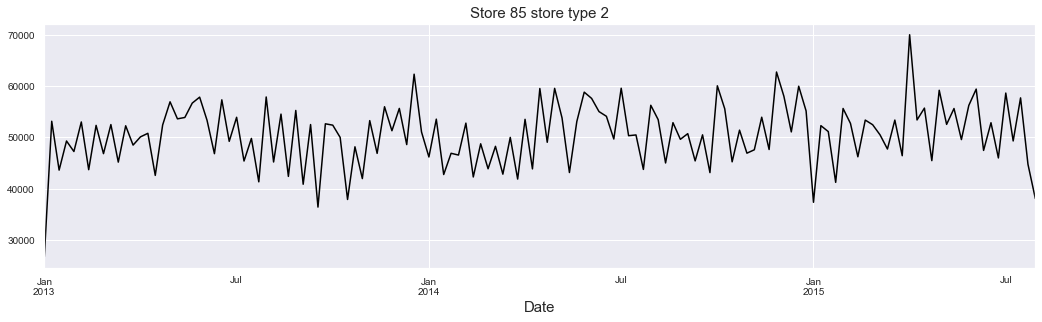

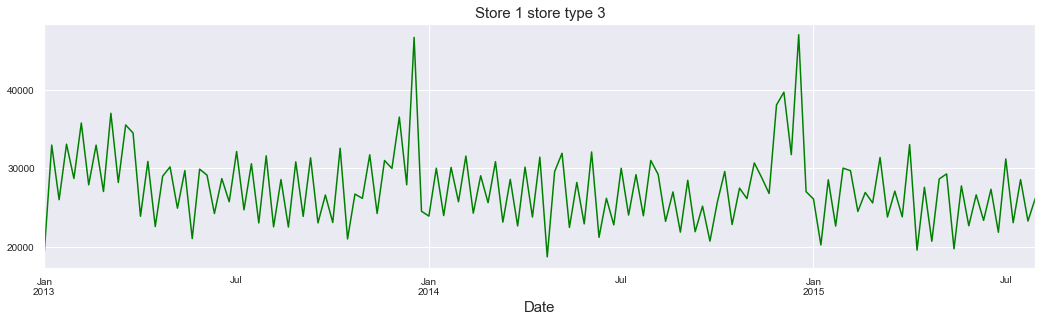

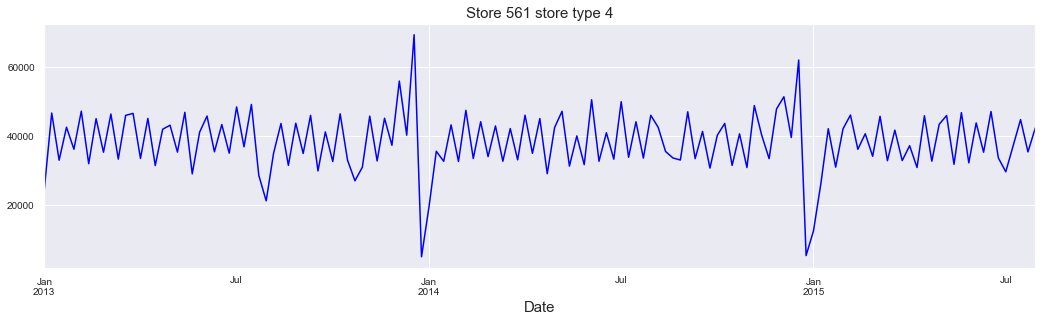

In [77]:
#Activation of function to present seasonality of Sales in selected Stores
seasonality(1115, "red", 1)
seasonality(85, "black", 2)
seasonality(1, "green", 3)
seasonality(561, "blue", 4)

Christmas and early summer are periods of significant sales increases in all types of stores. Furthermore, sales in Store Type 3 is on the lowest level in compare to other Store Types. Moreover, in Store Type 2 peaks during christmas and early summer are the most common to other periods of time, increases are least visible.

## 4.4 Visualization of Time Series - Trend

In [88]:
def trend(store_number, color, store_type):
    """
    Function to present plot showing trend of sales in selected store.
    Input:
    store_number: number of selected Store
    color: color of plot
    store_type: Store Type of selectes Store
    """
    rcParams["figure.figsize"] = 15, 5
    data['Sales'] = data['Sales'] * 1.0
    
    sales_a = data[data.Store == store_number]['Sales']
    
    decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
    decomposition_a.trend.plot(color = color)
    plt.title("Store " + str(store_number) + " store type " + str(store_type), fontsize= 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("Sales", fontsize=15)
    plt.xlabel("Date", fontsize=15)
    
    plt.tight_layout()
    plt.show()

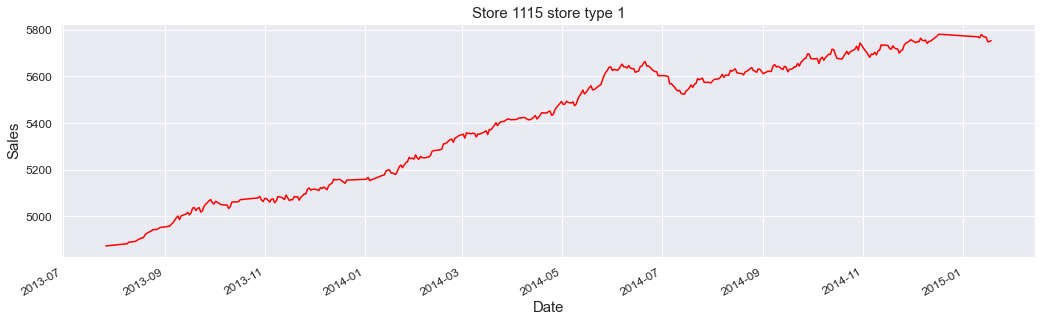

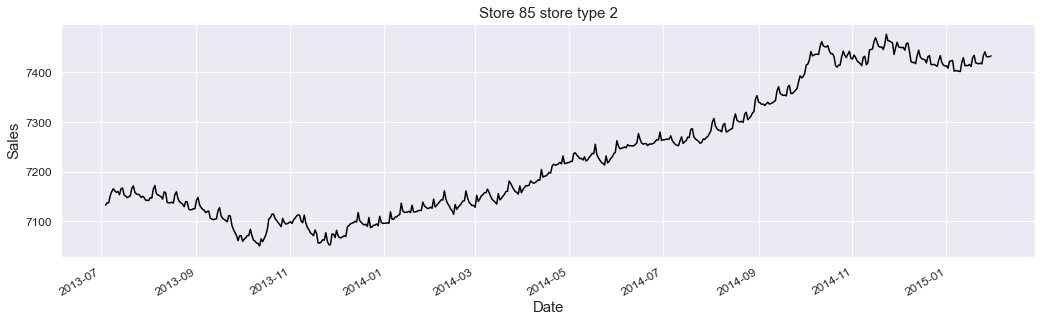

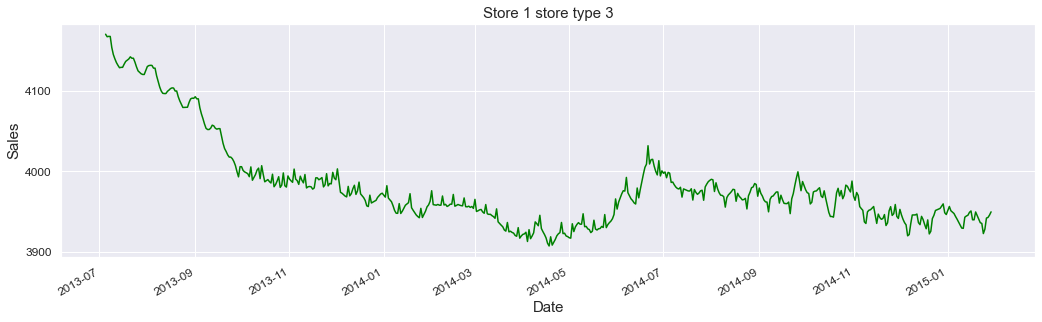

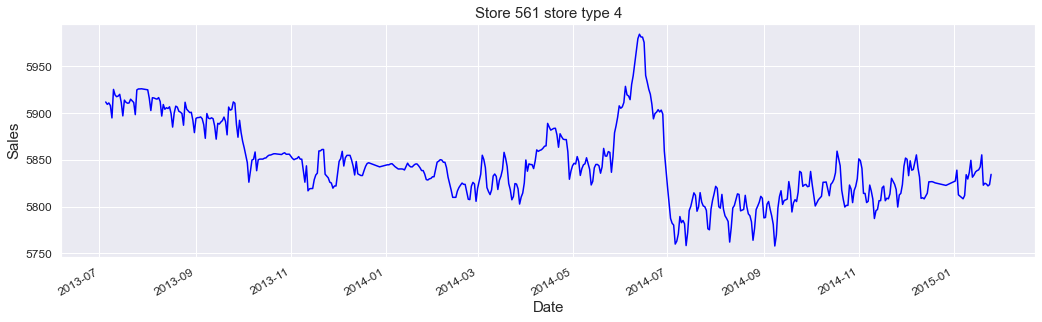

In [89]:
#Activation of created function to plot trend of sales in selected stores
trend(1115, "red", 1)
trend(85, "black", 2)
trend(1, "green", 3)
trend(561, "blue", 4)

Store Type 1 increase constantly. Similar situation was in terms of Store Type 2, where was constant growth but about October 2014 there was roughly equal level of sales. Moreover, in Store Type 3 there was sharp decline, but there was slight growth about July 2014, but after that, there was a renewed decline in sales. Clear rebound from the bottom was in terms of Store Type 4, where there has been a steady decline to January 2014, after that there was a steady sale till August 2014, then there was rapid growth.

# 5. Dummy coding

In [348]:
#Select categorical variables to dummy coding
categorical_var = data.select_dtypes(include=["object"]).columns.tolist()
categorical_var

['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

In [349]:
#Select categorical variables to dummy coding
categorical_columns = [x for x in data.select_dtypes(include=["object"]).columns.tolist() if x != "Sales"]
categorical_columns

['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

In [350]:
print("StateHoliday:", data["StateHoliday"].unique())
print("StoreType:", data["StoreType"].unique())
print("Assortment:", data["Assortment"].unique())
print("PromoInterval:", data["PromoInterval"].unique())

StateHoliday: ['a' '0' 'b' 'c' 0]
StoreType: ['b' 'd' 'a' 'c']
Assortment: ['a' 'c' 'b']
PromoInterval: [0 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [351]:
#Dummy coding of "sulphates_level" 
data=pd.get_dummies(data,
                    columns=categorical_columns,
                    drop_first=True) #parameter = True, so as to avoid collinearity

In [94]:
#Dataset after dummy coding
data

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,494,2,3113.000,527,1,0,1,1260.000,6.000,2011.000,...,0,0,1,0,0,0,0,0,0,0
2013-01-01,85,2,4220.000,619,1,0,1,1870.000,10.000,2011.000,...,0,0,1,0,0,0,0,0,0,0
2013-01-01,682,2,3375.000,566,1,0,1,150.000,9.000,2006.000,...,0,0,1,0,0,0,0,0,0,0
2013-01-01,676,2,3821.000,777,1,0,1,1410.000,9.000,2008.000,...,0,0,1,0,0,1,0,0,0,0
2013-01-02,371,3,7374.000,606,1,0,1,1970.000,7.000,2009.000,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,744,5,8663.000,943,1,1,0,1370.000,12.000,2011.000,...,0,0,0,0,0,0,0,0,1,0
2015-07-31,745,5,8363.000,746,1,1,1,17650.000,11.000,2013.000,...,0,0,0,0,0,0,0,0,1,0
2015-07-31,746,5,9082.000,638,1,1,1,4330.000,2.000,2011.000,...,0,0,0,0,1,0,1,0,0,1


# 6. CORR - Correlation - Pearson / Spearman

## 6.1 Correlation between target and independent variables

In [352]:
#Pearson correlation
corr_pearson = data.corr(method="pearson").abs()[["Sales"]].sort_values(by="Sales", ascending=False)
corr_pearson.rename(columns={"Sales" : "Sales_corr_pearson"}, inplace=True)
corr_pearson

,Sales_corr_pearson
Sales,1.000
Customers,0.892
Open,0.683
SalePerCustomer,0.672
DayOfWeek,0.464
Promo,0.461
StateHoliday_a,0.186
StoreType_b,0.102
StateHoliday_b,0.101
StateHoliday_0,0.094


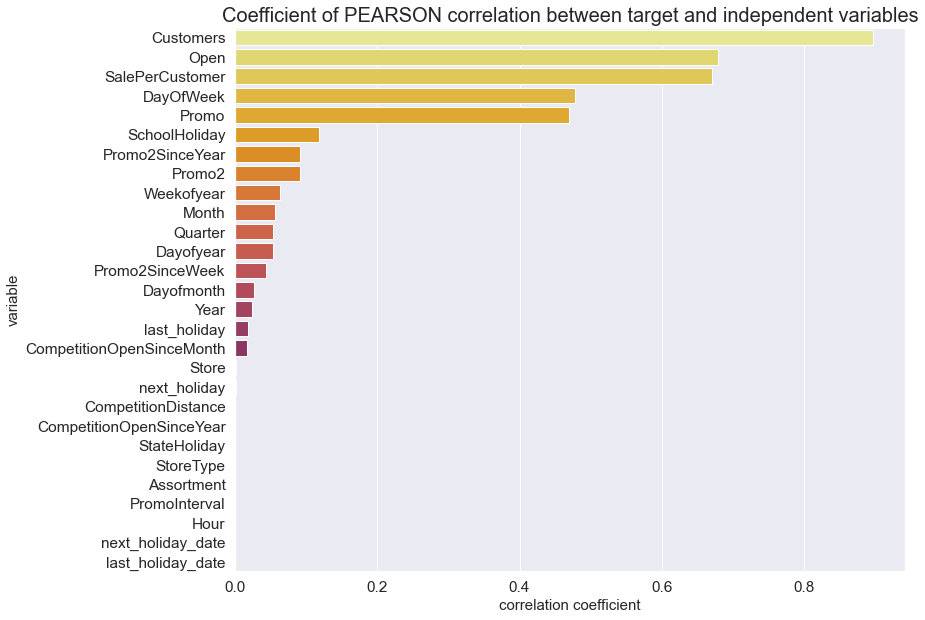

In [126]:
#Corr Pearson presented on barplot
#DF with Pearson corr
correlation_matrix = pd.DataFrame(np.abs(data.corr(method="pearson")), columns = data.columns, index = data.columns)
correlation_matrix.drop("Sales", axis = 0, inplace = True)
correlation_matrix.reset_index(inplace=True)

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.barplot(data = correlation_matrix.sort_values('Sales', ascending=False),
            x = 'Sales',
            y = 'index',
            palette = "inferno_r")
plt.title("Coefficient of PEARSON correlation between target and independent variables", fontsize=20)
plt.xlabel("correlation coefficient", fontsize=15)
plt.ylabel("variable", fontsize=15)
plt.savefig("CORR/Pearson_CORR_plot.png", bbox_inches = "tight")
plt.show()

In [353]:
#Spearman correlation
corr_spearman = data.corr(method="spearman").abs()[["Sales"]].sort_values(by="Sales", ascending=False)
corr_spearman.rename(columns={"Sales" : "Sales_corr_spearman"}, inplace=True)
corr_spearman

,Sales_corr_spearman
Sales,1.000
Customers,0.893
Open,0.625
SalePerCustomer,0.544
Promo,0.491
DayOfWeek,0.439
StateHoliday_a,0.171
StateHoliday_b,0.093
SchoolHoliday,0.092
StateHoliday_0,0.089


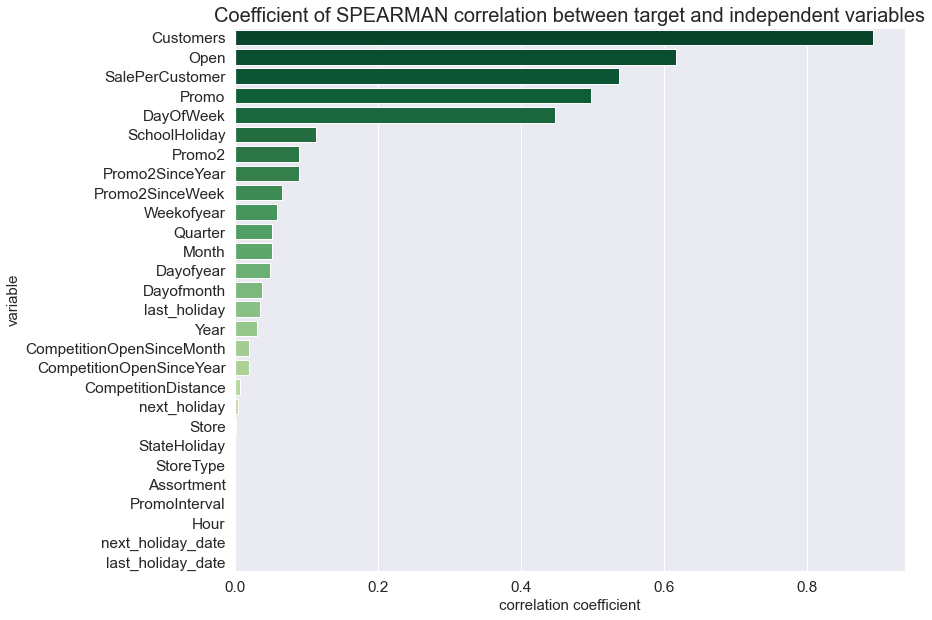

In [127]:
#Corr Spearman presented on barplot
#DF with Spearman corr
correlation_matrix = pd.DataFrame(np.abs(data.corr(method="spearman")), columns = data.columns, index = data.columns)
correlation_matrix.drop('Sales', axis = 0, inplace = True)
correlation_matrix.reset_index(inplace=True)

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.barplot(data = correlation_matrix.sort_values('Sales', ascending=False),
            x = 'Sales',
            y = 'index',
            palette = 'YlGn_r')
plt.title("Coefficient of SPEARMAN correlation between target and independent variables", fontsize=20)
plt.xlabel("correlation coefficient", fontsize=15)
plt.ylabel("variable", fontsize=15)
plt.savefig("CORR/Spearman_CORR_plot.png", bbox_inches = "tight")
plt.show()

In [354]:
#Merge of correlations data frames
corr_merge=pd.merge(corr_pearson,corr_spearman,left_index=True,right_index=True).sort_values(by=["Sales_corr_spearman",
                                                                                                 "Sales_corr_pearson"],
                                                                                                 ascending=False)
corr_merge.to_excel("CORR/CORR_Pearson_Spearman.xlsx")
corr_merge

,Sales_corr_pearson,Sales_corr_spearman
Sales,1.000,1.000
Customers,0.892,0.893
Open,0.683,0.625
SalePerCustomer,0.672,0.544
Promo,0.461,0.491
DayOfWeek,0.464,0.439
StateHoliday_a,0.186,0.171
StateHoliday_b,0.101,0.093
SchoolHoliday,0.091,0.092
StateHoliday_0,0.094,0.089


Spearman corr does not need normal distribution (in contrast to Pearson), so in this dataset Spearman is preferable CORR to use. Independent variables need to be high correlated with target (but not extremely high) so variables with extremely low and extremely high corr will be dropped.

In [355]:
#Highest corr with target - Spearman corr does not need normal distribution (in contrast to Pearson), so in this dataset
#Spearman is preferable CORR to use
corr_treshold = 0.70
high_corr = corr_merge[corr_merge["Sales_corr_spearman"] > corr_treshold][["Sales_corr_spearman"]].index.tolist()
corr_to_drop = [column for column in high_corr if column != "Sales"]
corr_to_drop

['Customers']

In [356]:
#Lowest corr with target - Spearman corr does not need normal distribution (in contrast to Pearson), so in this dataset
#Spearman is preferable CORR to use
corr_treshold_2 = 0.010
low_corr = corr_merge[corr_merge["Sales_corr_spearman"] < corr_treshold_2][["Sales_corr_spearman"]].index.tolist()
corr_to_drop_2 = [column for column in low_corr if column not in ["Sales", "Store"]]
#Variable Hour does not have corr, it will be also dropped
corr_to_drop_2.append("Hour")
corr_to_drop_2

['StoreType_c', 'Hour']

In [357]:
#Drop column with too high correlation with target based on Spearman corr
data.drop(columns=corr_to_drop, inplace=True)
#Drop columns with loo low correlation with target based on Spearman corr
data.drop(columns=corr_to_drop_2, inplace=True)

## 6.2 Correlation between independent variables

In [395]:
# #Heatmap of correlations - as above in this dataset Spearman corr is preferable
# plt.figure (figsize = (15,7)) 
# cor = data.corr(method="spearman").abs()
# sns.heatmap (cor, annot = True, annot_kws={"size": 11}, cmap = plt.cm.Reds) 
# plt.title("CORR Spearman between independent variables", fontsize=20)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.show()

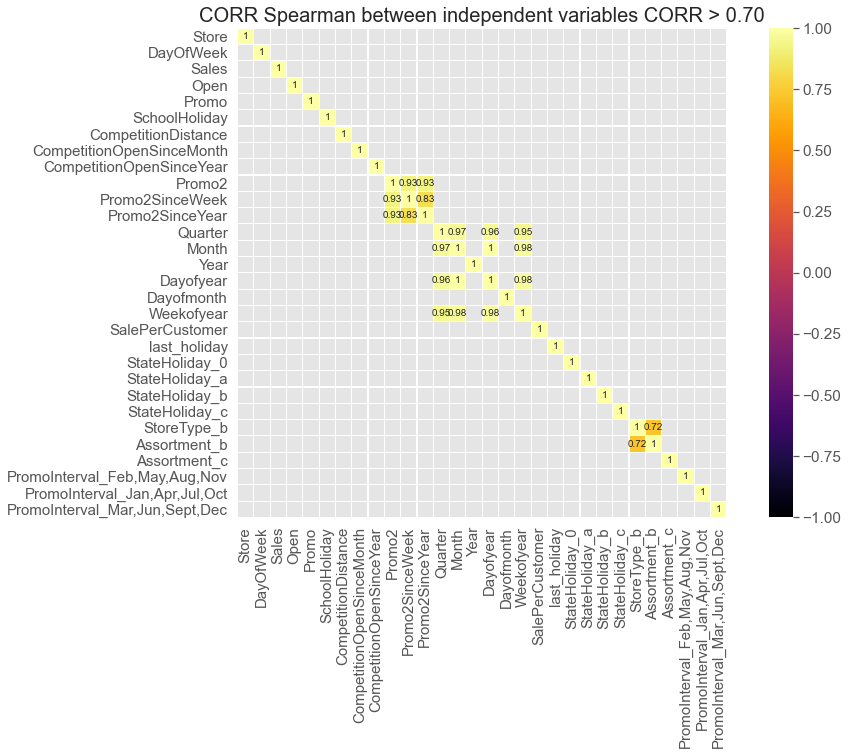

In [184]:
#Spearman correlation between independent variables, where CORR > 0.70
corr = data.corr(method="spearman").abs() 
plt.figure(figsize=(15, 9))

sns.heatmap(corr[(corr >= 0.7)], 
            cmap='inferno', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True)
plt.title("CORR Spearman between independent variables CORR > 0.70", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("CORR/CORR_higher_07_Spearman.png", bbox_inches = "tight")
plt.show()

In [358]:
#Columns to drop afret checking CORR between independent varaibles:

#Promo2SinceWeek - high correlated (0.84) with Promo2SinceYear and (0.93) with Promo2, but Promo2SinceYear and Promo2
#higher correlated with target (but not > 0.70 correlated with target)
#Assortment_b - high correlated (0.72) with StoreType_b, but StoreType_b is higher correlated with target 
#(but not > 0.70 correlated with target)

#Variables: Quarter, Month, Year, Dayofyear, Dayofmonth, Weekofyear will no be dropped

#Dropping high correlated variables (with other independent variables)
data.drop(columns=["Promo2SinceWeek", "Assortment_b"], inplace=True)

# 7. Logarithm of the target variable

Dropping observations where Sales is 0 because after logarithm of target in observations where Sales (target) is 0 wil be value -inf. Moreover, if actual value of target is 0 there will be huge problem to calculate for example MAPE in further part of analysis.

In [404]:
#Shape of dataset before and after removing observations where Sales = 0
print("Obs. before removing obs with Sales = 0:", data.shape[0])
print("Obs. with Sales = 0:", data[data["Sales"]== 0].shape[0])
print("Obs. after removing obs with Sales = 0:", data.shape[0] - data[data["Sales"]== 0].shape[0])

Obs. before removing obs with Sales = 0: 966348
Obs. with Sales = 0: 143488
Obs. after removing obs with Sales = 0: 822860


In [359]:
#Dropping observations where Sales is 0
#data.drop(index = data[data["Sales"]== 0].index, inplace = True, axis = 0)
data = data[data["Sales"] != 0]

#Logarithm of target variable
data["Sales"] = np.log(data["Sales"])

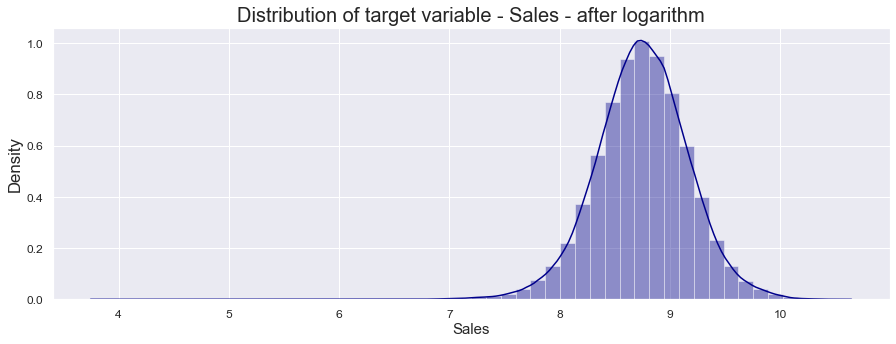

In [411]:
#Distribution of target variable (Sales) after logarithm this dependent variable
rcParams["figure.figsize"] = 15, 5 
sns.distplot(data["Sales"], color="darkblue")
plt.title("Distribution of target variable - Sales - after logarithm", fontsize= 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Sales",fontsize=15)
plt.show()

Data has been divided on 2 identical datasets so as to be sure that input dataset will be the same for each model and so as to avoid eventual modification during modelling which could have impact during construction next model.

In [360]:
#Dataset for ARIMA - with logarithm of target variable
data.to_csv("data_ARIMA.csv")
#Dataset for XGBoost - with logarithm of target variable
data.to_csv("data_XGB.csv")

# 8. Machine Learning Models

## 8.1 ARIMA

In [415]:
#Dataset for ARIMA
data = pd.read_csv("data_ARIMA.csv")
data["Date"] = data["Date"].astype("datetime64")
data.sort_values(by="Date", inplace=True)
data.set_index("Date", inplace=True)

### 8.1.1  Train / test split

In [416]:
#train test split 60% / 40%
train_set = data[:"2014-07-02"]
test_set = data["2014-07-03":]

In [551]:
#Separate target variable from TRAIN and TEST dataset to plot it
sample_train = train_set[["Sales"]]
sample_test = test_set[["Sales"]]

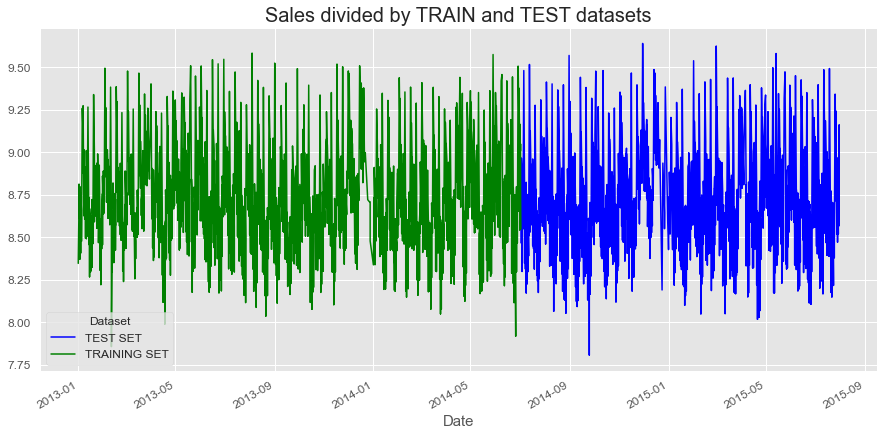

In [557]:
plt.style.use('ggplot')
temp_plot = sample_test \
    .rename(columns={'Sales': 'TEST SET'}) \
    .merge(sample_train.rename(columns={'Sales': 'TRAINING SET'}), how='outer', left_index=True, right_index=True) \
    .plot(figsize=(15,7), style='-', color= ["blue", "green"])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Date",fontsize=15)
plt.title("Sales divided by TRAIN and TEST datasets", fontsize=20)
plt.legend(loc="best",
           prop={"size": 12},
           title="Dataset",
           title_fontsize="12",
           frameon=True)
plt.show()

### 8.1.2 ACF and PACF plots

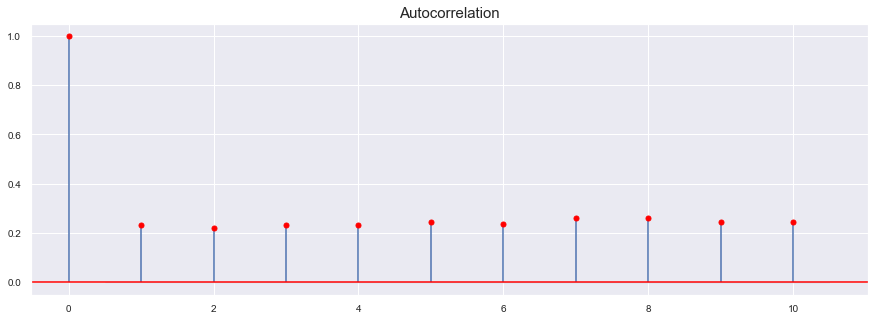

In [418]:
#ACF plot
rcParams["figure.figsize"] = 15, 5
plot_acf(data["Sales"],lags=10, color="red")
plt.title("Autocorrelation", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

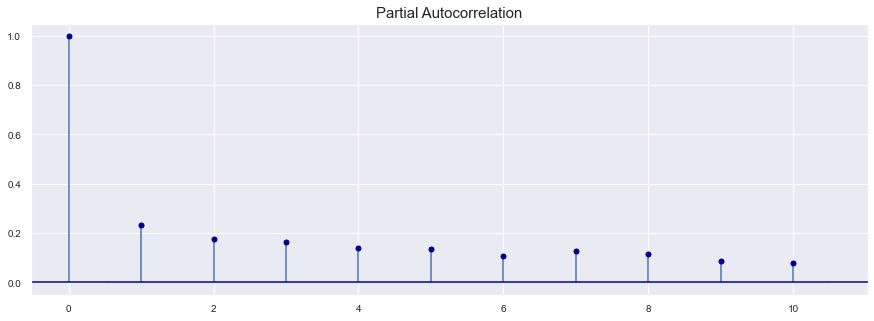

In [415]:
#PACF plot
#plt.figure(figsize=(15,5))
rcParams["figure.figsize"] = 15, 5
plot_pacf(data["Sales"],lags=10, color="darkblue")
plt.title("Partial Autocorrelation", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### 8.1.3 Checking stationary of series

#### Augmented Dickey-Fuller Test

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

The output from the below code means that the series is not stationary and it is needed to make it a stationary series first to implement ARIMA.
Here’s when auto Arima is useful, it automatically determines the differencing parameter ‘d’ to make the series stationary.

In [419]:
#Checking stationary by ADFTest from pmdarima.arima
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(train_set["Sales"])

(0.01, False)

In [ ]:
# print("p-value:", adfuller(data["Sales"].dropna())[1])

### 8.1.4 Tunning of hiper parameters by loop

* AR(p) Autoregression – a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.
* I(d) Integration – uses differencing of observations (subtracting an observation from observation at the previous time step) in order to make the time series stationary. Differencing involves the subtraction of the current values of a series with its previous values d number of times.
* MA(q) Moving Average – a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.

In [33]:
#Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

Because some parameter combinations may lead to numerical misspecifications, we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we make sure to catch these exceptions and ignore the parameter combinations that cause these issues.

In [37]:
#Loop to find the best configuration of ARIMA order parametr based on AIC and BIC
for param in pdq:
    try:
        mod = ARIMA(train_set["Sales"], order=param)

        results = mod.fit()
        print('ARIMA{} - AIC:{} - BIC:{}'.format(param, results.aic, results.bic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:11129147.673429526 - BIC:11129170.216344113
ARIMA(0, 0, 1) - AIC:11007836.429022841 - BIC:11007870.243394721
ARIMA(0, 1, 0) - AIC:11064520.007300226 - BIC:11064542.550211366
ARIMA(0, 1, 1) - AIC:10689375.792829327 - BIC:10689409.607196039
ARIMA(1, 0, 0) - AIC:10917603.99273044 - BIC:10917637.80710232
ARIMA(1, 1, 0) - AIC:10904247.925591081 - BIC:10904281.739957793


The best configuration of order parameter of ARIMA model for train_set is: (0, 1, 1) because of the lowest AIC and BIC (information criteria).

### 8.1.5 Tunning of hiper parameters by auto_arima

Execution of code of auto_arima is really long, so p, q, d was chose by above loop.

In [18]:
#Really long time execution
# auto_arima_fit = auto_arima(data["Sales"],
#                             start_p=0,
#                             start_q=0,
#                             start_d=0,
#                             max_p=1,
#                             max_q=1,
#                             max_d=1,
#                             m=12,
#                             start_P=0,
#                             seasonal=True,
#                             d=1,
#                             D=1,
#                             trace=True,
#                             error_action='ignore',
#                             suppress_warnings=True,
#                             stepwise=True)

### 8.1.6 Loop to make forecast of sales for many selected stores by ARIMA

Loop prepared to compare forecasts and evaluation of a few Stores. Possibility to implement a few stores to input list.

In [417]:
#Loop to generate forecast on train and test datasets for selected Stores - NOT only one Store

#DF with certain store
sample_df = data.query('Store in [85, 1, 561, 353, 682, 682, 494, 274, 423, 353]')

#Lista uniklanych sklepów i unikalnych towarów
Store_list = sample_df["Store"].unique().tolist()

#Range of train and test datasets
train_set = sample_df[:'2014-07-02']
test_set = sample_df["2014-07-03":]

#Data Frame for results on TRAIN dataset
df_TRAIN_result = pd.DataFrame(columns=["Date", "Store", "Sales", "Sales_predicted"])
df_TRAIN_result.set_index("Date", inplace=True)
    
#Data Frame for results on TEST dataset
df_TEST_result = pd.DataFrame(columns=["Date", "Store", "Sales", "Sales_predicted"])
df_TEST_result.set_index("Date", inplace=True)

#List for Stores on TRAIN dataset
store_list_TRAIN = list()
#List for evaluation on TRAIN dataset
mse_list_TRAIN = list()
rmse_list_TRAIN = list()
mape_list_TRAIN = list()
mae_list_TRAIN = list()

#List for Stores on TEST dataset
store_list_TEST = list()
#List for evaluation on TEST dataset
mse_list_TEST = list()
rmse_list_TEST = list()
mape_list_TEST = list()
mae_list_TEST = list()

#Loop for store
for store in Store_list:
        
    ####################################### ARIMA MODEL ###################################################
        
    #Data Frame with modelling Store number
    ARIMA_TRAIN=train_set[(train_set["Store"] == store)][["Store","Sales"]]
    ARIMA_TRAIN.reset_index(inplace=True)
    ARIMA_TRAIN.sort_values(by="Date", ascending =True, inplace=True)
    ARIMA_TRAIN.set_index(["Date"],inplace=True)
        
    #ARIMA model building
    model = ARIMA(ARIMA_TRAIN["Sales"], order = (0,1,1))
    result = model.fit(disp=0)
        
    ####################################### PREDICTION ON TRAIN ############################################
        
    #Prediction on TRAIN dataset
    predicted_TRAIN = result.predict(start=1, end=len(ARIMA_TRAIN), typ = 'levels')
    predicted_TRAIN = predicted_TRAIN.reset_index(drop=True)
    predicted_TRAIN.index = ARIMA_TRAIN.index
        
    #Data Frame with actual and prediction on TRAIN dataset
    predicted_df_TRAIN = pd.DataFrame(data=predicted_TRAIN, columns=['Sales_predicted'], index=ARIMA_TRAIN.index.copy())
    df_out_TRAIN = pd.merge(ARIMA_TRAIN, predicted_df_TRAIN, how ='left', left_index=True, right_index=True)
        
    #Data Frame: Date x Store x Sales (actual) X Sales_predicted (predicted) on TRAIN dataset
    df_TRAIN_result = pd.concat([df_TRAIN_result, df_out_TRAIN])
    df_TRAIN_result.sort_index(ascending=True, inplace=True)
    
    ####################################### EVALUATION ON TRAIN ############################################
    
    #RMSE TRAIN
    RMSE_TRAIN = rmse(df_out_TRAIN["Sales"], df_out_TRAIN["Sales_predicted"]) 
    #MSE TRAIN
    MSE_TRAIN = mean_squared_error(df_out_TRAIN["Sales"], df_out_TRAIN["Sales_predicted"]) 
    #MAPE TRAIN
    actual, pred = np.array(df_out_TRAIN["Sales"]), np.array(df_out_TRAIN["Sales_predicted"])
    MAPE_TRAIN = np.mean(np.abs((actual - pred) / actual)) * 100
    #MAE TRAIN
    MAE_TRAIN = mean_absolute_error(df_out_TRAIN["Sales"], df_out_TRAIN["Sales_predicted"]) 
    
    store_list_TRAIN.append(store)
    rmse_list_TRAIN.append(RMSE_TRAIN)
    mse_list_TRAIN.append(MSE_TRAIN)
    mape_list_TRAIN.append(MAPE_TRAIN)
    mae_list_TRAIN.append(MAE_TRAIN)
        
    ####################################### PREDICTION ON TEST ############################################
        
    #Data Frame (TEST) to predict
    ARIMA_TEST=test_set[(test_set["Store"] == store)][["Store","Sales"]]
    ARIMA_TEST.reset_index(inplace=True)
    ARIMA_TEST.sort_values(by="Date", ascending =True, inplace=True)
    ARIMA_TEST.set_index(["Date"],inplace=True)
        
    #Prediction on TEST dataset
    predicted_TEST = result.predict(start=1, end=len(ARIMA_TEST), typ = 'levels')
    predicted_TEST = predicted_TEST.reset_index(drop=True)
    predicted_TEST.index = ARIMA_TEST.index
        
    #Data Frame with actual and prediction on TEST dataset
    predicted_df_TEST = pd.DataFrame(data=predicted_TEST, columns=['Sales_predicted'], index=ARIMA_TEST.index.copy())
    df_out_TEST = pd.merge(ARIMA_TEST, predicted_df_TEST, how ='left', left_index=True, right_index=True)
    
    #Data Frame: Date x Store x Sales (actual) X Sales_predicted (predicted) on TEST dataset
    df_TEST_result = pd.concat([df_TEST_result, df_out_TEST])
    df_TEST_result.sort_index(ascending=True, inplace=True)
    
    ####################################### EVALUATION ON TEST ############################################
    
    #RMSE TEST
    RMSE_TEST = rmse(df_out_TEST["Sales"], df_out_TEST["Sales_predicted"]) 
    #MSE TEST
    MSE_TEST = mean_squared_error(df_out_TEST["Sales"], df_out_TEST["Sales_predicted"]) 
    #MAPE TEST
    actual, pred = np.array(df_out_TEST["Sales"]), np.array(df_out_TEST["Sales_predicted"])
    MAPE_TEST = np.mean(np.abs((actual - pred) / actual)) * 100
    #MAE TEST
    MAE_TEST = mean_absolute_error(df_out_TEST["Sales"], df_out_TEST["Sales_predicted"]) 
    
    store_list_TEST.append(store)
    rmse_list_TEST.append(RMSE_TEST)
    mse_list_TEST.append(MSE_TEST)
    mape_list_TEST.append(MAPE_TEST)
    mae_list_TEST.append(MAE_TEST)
    
    ################################ DATASETS WITH EVALUATION ON TEST / TRAIN #####################################

    #Data Frame with evaluation statistics on TEST dataset   
    evaluation_TEST = pd.DataFrame()
    evaluation_TEST["Store"] = store_list_TEST
    evaluation_TEST["MAPE_test_ARIMA"] = mape_list_TEST
    evaluation_TEST["MSE_test_ARIMA"] = mse_list_TEST
    evaluation_TEST["RMSE_test_ARIMA"] = rmse_list_TEST
    evaluation_TEST["MAE_test_ARIMA"] = mae_list_TEST
    evaluation_TEST.set_index("Store", inplace=True)

    #Data Frame with evaluation statistics on TRAIN dataset   
    evaluation_TRAIN = pd.DataFrame()
    evaluation_TRAIN["Store"] = store_list_TRAIN
    evaluation_TRAIN["MAPE_train_ARIMA"] = mape_list_TRAIN
    evaluation_TRAIN["MSE_train_ARIMA"] = mse_list_TRAIN
    evaluation_TRAIN["RMSE_train_ARIMA"] = rmse_list_TRAIN
    evaluation_TRAIN["MAE_train_ARIMA"] = mae_list_TRAIN
    evaluation_TRAIN.set_index("Store", inplace=True)
    
    #Comparision of evaluation on TRAIN and TEST datasets
    comparision_evaluation_loop_arima = pd.merge(evaluation_TEST, evaluation_TRAIN, left_index = True, right_index = True)
    comparision_evaluation_loop_arima = comparision_evaluation_loop_arima[["MAE_test_ARIMA", "MAE_train_ARIMA",
                                                     "MAPE_test_ARIMA", "MAPE_train_ARIMA",
                                                     "MSE_test_ARIMA", "MSE_train_ARIMA",
                                                     "RMSE_test_ARIMA", "RMSE_train_ARIMA"]]

Generally, results on train and test dataset are similar, so probably there is no overfitting. But in some Stores could be not enought observations to make good prediction, and in this case could be overfitting and if some store does not have enought observation, foracast of sales could be even impossible. In this situation is recommended to increase the number of observations for stores that have few observations.

In [418]:
#Comparision of evaluation of forecast for selected Soters
comparision_evaluation_loop_arima.to_excel("ARIMA_results/comparision_a_few_stores/comparision_evaluation.xlsx")
comparision_evaluation_loop_arima

,MAE_test_ARIMA,MAE_train_ARIMA,MAPE_test_ARIMA,MAPE_train_ARIMA,MSE_test_ARIMA,MSE_train_ARIMA,RMSE_test_ARIMA,RMSE_train_ARIMA
Store,,,,,,,,
494,0.222,0.094,2.483,1.059,0.077,0.017,0.277,0.129
85,0.206,0.217,2.294,2.431,0.076,0.075,0.275,0.274
1,0.240,0.024,2.857,0.287,0.091,0.001,0.302,0.033
423,0.162,0.141,1.746,1.525,0.044,0.030,0.210,0.172
682,0.241,0.251,2.614,2.725,0.084,0.092,0.290,0.303
561,0.205,0.207,2.326,2.352,0.061,0.062,0.246,0.249
353,0.300,0.129,3.399,1.505,0.130,0.029,0.361,0.170
274,0.279,0.198,3.256,2.382,0.148,0.069,0.385,0.262


In [301]:
#Forecast on train dataset
df_TRAIN_result.to_excel("ARIMA_results/comparision_a_few_stores/ARIMA_forecast_train_dataset.xlsx")
df_TRAIN_result

,Store,Sales,Sales_predicted
Date,,,
2013-01-01,353,8.052,8.053
2013-01-01,423,9.174,9.174
2013-01-01,85,8.348,8.348
2013-01-01,274,8.040,8.041
2013-01-01,682,8.124,8.124
...,...,...,...
2014-07-02,353,8.743,8.718
2014-07-02,682,9.615,9.254
2014-07-02,274,8.177,8.353


In [302]:
#Forecast on test dataset
df_TEST_result.to_excel("ARIMA_results/comparision_a_few_stores/ARIMA_forecast_test_dataset.xlsx")
df_TEST_result

,Store,Sales,Sales_predicted
Date,,,
2014-07-03,353,8.717,8.053
2014-07-03,274,8.304,8.041
2014-07-03,423,9.357,9.174
2014-07-03,85,8.865,8.348
2014-07-03,1,8.467,8.618
...,...,...,...
2015-07-31,682,9.545,9.250
2015-07-31,423,9.498,9.179
2015-07-31,274,8.850,8.230


### 8.1.7 Function for business user to create forecast for one store by ARIMA

Function for business user to create forecast for one direct store.

In [303]:
def ARIMA_model_building(store_number, output):
    """
    Function to create ARIMA model to make forecast for one selected store.
    Input:
    store_number: number of store to make forecast
    output: Kind of DataFrame with different values: "test_forecast", "train_forecast", "test_evaluation", "train_Evaluation",
    "comparision_evaluation".
    """
    #Loop to generate forecast on train and test datasets for selected Stores - only one Store

    #DF with certain store
    #sample_df = data.query('Store in ' + str(list(store_number)))
    sample_df = data[data["Store"]==store_number]

    #Lista uniklanych sklepów i unikalnych towarów
    Store_list = sample_df["Store"].unique().tolist()

    #Range of train and test datasets
    train_set = sample_df[:'2014-07-02']
    test_set = sample_df["2014-07-03":]

    #Data Frame for results on TRAIN dataset
    df_TRAIN_result = pd.DataFrame(columns=["Date", "Store", "Sales", "Sales_predicted"])
    df_TRAIN_result.set_index("Date", inplace=True)
    
    #Data Frame for results on TEST dataset
    df_TEST_result = pd.DataFrame(columns=["Date", "Store", "Sales", "Sales_predicted"])
    df_TEST_result.set_index("Date", inplace=True)

    #List for Stores on TRAIN dataset
    store_list_TRAIN = list()
    #List for evaluation on TRAIN dataset
    mse_list_TRAIN = list()
    rmse_list_TRAIN = list()
    mape_list_TRAIN = list()
    mae_list_TRAIN = list()

    #List for Stores on TEST dataset
    store_list_TEST = list()
    #List for evaluation on TEST dataset
    mse_list_TEST = list()
    rmse_list_TEST = list()
    mape_list_TEST = list()
    mae_list_TEST = list()

    #Loop for store
    for store in Store_list:
        
        ####################################### ARIMA MODEL ###################################################
        
        #Data Frame with modelling Store number
        ARIMA_TRAIN=train_set[(train_set["Store"] == store)][["Store","Sales"]]
        ARIMA_TRAIN.reset_index(inplace=True)
        ARIMA_TRAIN.sort_values(by="Date", ascending =True, inplace=True)
        ARIMA_TRAIN.set_index(["Date"],inplace=True)
        
        #ARIMA model building
        model = ARIMA(ARIMA_TRAIN["Sales"], order = (0,1,1))
        result = model.fit(disp=0)
        
        ####################################### PREDICTION ON TRAIN ############################################
        
        #Prediction on TRAIN dataset
        predicted_TRAIN = result.predict(start=1, end=len(ARIMA_TRAIN), typ = 'levels')
        predicted_TRAIN = predicted_TRAIN.reset_index(drop=True)
        predicted_TRAIN.index = ARIMA_TRAIN.index
        
        #Data Frame with actual and prediction on TRAIN dataset
        predicted_df_TRAIN = pd.DataFrame(data=predicted_TRAIN, columns=['Sales_predicted'], index=ARIMA_TRAIN.index.copy())
        df_out_TRAIN = pd.merge(ARIMA_TRAIN, predicted_df_TRAIN, how ='left', left_index=True, right_index=True)
        
        #Data Frame: Date x Store x Sales (actual) X Sales_predicted (predicted) on TRAIN dataset
        df_TRAIN_result = pd.concat([df_TRAIN_result, df_out_TRAIN])
        df_TRAIN_result.sort_index(ascending=True, inplace=True)
    
        ####################################### EVALUATION ON TRAIN ############################################
    
        #RMSE TRAIN
        RMSE_TRAIN = rmse(df_out_TRAIN["Sales"], df_out_TRAIN["Sales_predicted"]) 
        #MSE TRAIN
        MSE_TRAIN = mean_squared_error(df_out_TRAIN["Sales"], df_out_TRAIN["Sales_predicted"]) 
        #MAPE TRAIN
        actual, pred = np.array(df_out_TRAIN["Sales"]), np.array(df_out_TRAIN["Sales_predicted"])
        MAPE_TRAIN = np.mean(np.abs((actual - pred) / actual)) * 100
        #MAE TRAIN
        MAE_TRAIN = mean_absolute_error(df_out_TRAIN["Sales"], df_out_TRAIN["Sales_predicted"]) 
    
        store_list_TRAIN.append(store)
        rmse_list_TRAIN.append(RMSE_TRAIN)
        mse_list_TRAIN.append(MSE_TRAIN)
        mape_list_TRAIN.append(MAPE_TRAIN)
        mae_list_TRAIN.append(MAE_TRAIN)
        
        ####################################### PREDICTION ON TEST ############################################
        
        #Data Frame (TEST) to predict
        ARIMA_TEST=test_set[(test_set["Store"] == store)][["Store","Sales"]]
        ARIMA_TEST.reset_index(inplace=True)
        ARIMA_TEST.sort_values(by="Date", ascending =True, inplace=True)
        ARIMA_TEST.set_index(["Date"],inplace=True)
        
        #Prediction on TEST dataset
        predicted_TEST = result.predict(start=1, end=len(ARIMA_TEST), typ = 'levels')
        predicted_TEST = predicted_TEST.reset_index(drop=True)
        predicted_TEST.index = ARIMA_TEST.index
        
        #Data Frame with actual and prediction on TEST dataset
        predicted_df_TEST = pd.DataFrame(data=predicted_TEST, columns=['Sales_predicted'], index=ARIMA_TEST.index.copy())
        df_out_TEST = pd.merge(ARIMA_TEST, predicted_df_TEST, how ='left', left_index=True, right_index=True)
    
        #Data Frame: Date x Store x Sales (actual) X Sales_predicted (predicted) on TEST dataset
        df_TEST_result = pd.concat([df_TEST_result, df_out_TEST])
        df_TEST_result.sort_index(ascending=True, inplace=True)
    
        ####################################### EVALUATION ON TEST ##################################################
    
        #RMSE TEST
        RMSE_TEST = rmse(df_out_TEST["Sales"], df_out_TEST["Sales_predicted"]) 
        #MSE TEST
        MSE_TEST = mean_squared_error(df_out_TEST["Sales"], df_out_TEST["Sales_predicted"]) 
        #MAPE TEST
        actual, pred = np.array(df_out_TEST["Sales"]), np.array(df_out_TEST["Sales_predicted"])
        MAPE_TEST = np.mean(np.abs((actual - pred) / actual)) * 100
        #MAE TEST
        MAE_TEST = mean_absolute_error(df_out_TEST["Sales"], df_out_TEST["Sales_predicted"])
    
        store_list_TEST.append(store)
        rmse_list_TEST.append(RMSE_TEST)
        mse_list_TEST.append(MSE_TEST)
        mape_list_TEST.append(MAPE_TEST)
        mae_list_TEST.append(MAE_TEST)
        
        ################################ DATASETS WITH EVALUATION ON TEST / TRAIN #####################################

        #Data Frame with evaluation statistics on TEST dataset   
        evaluation_TEST = pd.DataFrame()
        evaluation_TEST["Store"] = store_list_TEST
        evaluation_TEST["MAPE_test_ARIMA"] = mape_list_TEST
        evaluation_TEST["MSE_test_ARIMA"] = mse_list_TEST
        evaluation_TEST["RMSE_test_ARIMA"] = rmse_list_TEST
        evaluation_TEST["MAE_test_ARIMA"] = mae_list_TEST
        evaluation_TEST.set_index("Store", inplace=True)

        #Data Frame with evaluation statistics on TRAIN dataset   
        evaluation_TRAIN = pd.DataFrame()
        evaluation_TRAIN["Store"] = store_list_TRAIN
        evaluation_TRAIN["MAPE_train_ARIMA"] = mape_list_TRAIN
        evaluation_TRAIN["MSE_train_ARIMA"] = mse_list_TRAIN
        evaluation_TRAIN["RMSE_train_ARIMA"] = rmse_list_TRAIN
        evaluation_TRAIN["MAE_train_ARIMA"] = mae_list_TRAIN
        evaluation_TRAIN.set_index("Store", inplace=True)
        
        #Comparision of evaluation on TRAIN and TEST datasets
        comparision_evaluation = pd.merge(evaluation_TEST, evaluation_TRAIN, left_index = True, right_index = True)
        comparision_evaluation = comparision_evaluation[["MAE_test_ARIMA", "MAE_train_ARIMA",
                                                         "MAPE_test_ARIMA", "MAPE_train_ARIMA",
                                                         "MSE_test_ARIMA", "MSE_train_ARIMA",
                                                         "RMSE_test_ARIMA", "RMSE_train_ARIMA"]]
        
        
         ####################################### WHICH RESULT DISPLAY ##############################################
            
        if output == "train_forecast":
            return df_TRAIN_result
        elif output == "test_forecast":
            return df_TEST_result
        elif output == "train_evaluation":
            return evaluation_TRAIN
        elif output == "test_evaluation":
            return evaluation_TEST
        elif output == "comparision_evaluation":
            return comparision_evaluation
        else:
            return "Choose in output parameter: 'train_forecast' / 'test_forecast', 'train_evaluation', 'test_evaluation', \
            'comparision_evaluation' to generate output."

### 8.1.8 Evaluation and visualization of forecast by ARIMA

In [304]:
#comparision of statistics of train and test dataset
ARIMA_model_building(1, "comparision_evaluation").to_excel("ARIMA_results/Store_1_forecast/ARIMA_comparision_evaluation.xlsx")
ARIMA_model_building(1, "comparision_evaluation")

,MAE_test_ARIMA,MAE_train_ARIMA,MAPE_test_ARIMA,MAPE_train_ARIMA,MSE_test_ARIMA,MSE_train_ARIMA,RMSE_test_ARIMA,RMSE_train_ARIMA
Store,,,,,,,,
1,0.241,0.024,2.869,0.287,0.091,0.001,0.302,0.033


In [305]:
#Results of model in train dataset
ARIMA_model_building(1, "train_forecast").to_excel("ARIMA_results/Store_1_forecast/ARIMA_train_forecast.xlsx")
ARIMA_model_building(1, "train_forecast")

,Store,Sales,Sales_predicted
Date,,,
2013-01-02,1,8.618,8.618
2013-01-03,1,8.373,8.419
2013-01-04,1,8.409,8.411
2013-01-05,1,8.517,8.496
2013-01-07,1,8.878,8.802
...,...,...,...
2014-06-27,1,8.299,8.235
2014-06-28,1,8.549,8.487
2014-06-30,1,8.655,8.621


In [238]:
#Evaluation of model on train dataset
ARIMA_model_building(1, "train_evaluation")

,MAPE_train_ARIMA,MSE_train_ARIMA,RMSE_train_ARIMA,MAE_train_ARIMA
Store,,,,
1,0.287,0.001,0.033,0.024


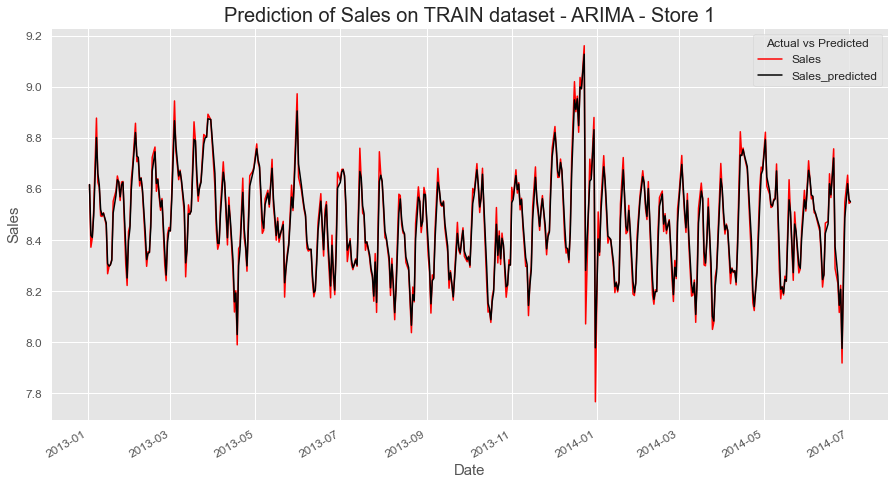

In [306]:
#Plot with prediction of ARIMA on train dataset - compare actual vs predicted sales
ARIMA_model_building(1, "train_forecast")[["Sales", "Sales_predicted"]].plot(figsize=(15, 8),
                                                                                        style=['-','-'],
                                                                                        color=["red", "black"])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Sales",fontsize=15)
plt.title("Prediction of Sales on TRAIN dataset - ARIMA - Store 1", fontsize=20)
plt.legend(loc="best",
           prop={"size": 12},
           title="Actual vs Predicted",
           title_fontsize="12",
           frameon=True)
plt.savefig("ARIMA_results/Store_1_forecast/forecast_plot_TRAIN_ARIMA.png", bbox_inches = "tight")
plt.show()

In [307]:
#Prediction by ARIMA on test dataset
ARIMA_model_building(1, "test_forecast").to_excel("ARIMA_results/Store_1_forecast/ARIMA_test_forecast.xlsx")
ARIMA_model_building(1, "test_forecast")

,Store,Sales,Sales_predicted
Date,,,
2014-07-03,1,8.467,8.618
2014-07-04,1,8.300,8.419
2014-07-05,1,8.552,8.411
2014-07-07,1,8.348,8.496
2014-07-08,1,8.314,8.802
...,...,...,...
2015-07-27,1,8.716,8.441
2015-07-28,1,8.519,8.239
2015-07-29,1,8.473,8.194


In [241]:
#Evaluation of ARIMA results from test datast
ARIMA_model_building(1, "test_evaluation")

,MAPE_test_ARIMA,MSE_test_ARIMA,RMSE_test_ARIMA,MAE_test_ARIMA
Store,,,,
1,2.869,0.091,0.302,0.241


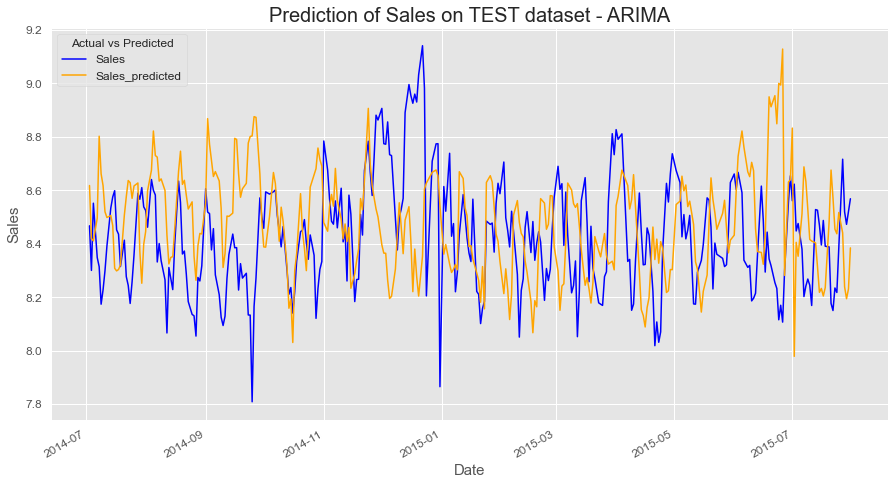

In [308]:
#Plot with comparision of actual vs predicted sales on test dataset
ARIMA_model_building(1, "test_forecast")[["Sales", "Sales_predicted"]].plot(figsize=(15, 8),
                                                                                        style=['-','-'],
                                                                                        color=["blue", "orange"])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Sales",fontsize=15)
plt.title("Prediction of Sales on TEST dataset - ARIMA", fontsize=20)
plt.legend(loc="best",
           prop={"size": 12},
           title="Actual vs Predicted",
           title_fontsize="12",
           frameon=True)
plt.savefig("ARIMA_results/Store_1_forecast/forecast_plot_TEST_ARIMA.png", bbox_inches = "tight")
plt.show()

## 8.2 XGBoost

In [419]:
#Dataset for XGBoost 
data_XGB = pd.read_csv("data_XGB.csv")
data_XGB["Date"] = data_XGB["Date"].astype("datetime64")
data_XGB.sort_values(by="Date", inplace=True)
data_XGB.set_index("Date", inplace=True)

#Delete observations with Sales = 0
data_XGB = data_XGB[data_XGB["Sales"] != 0]

#Delete columns with data - not important from business point of view, because of existing variables concerning number of days
#until and after holiday 
data_XGB.drop(columns=["next_holiday_date", "last_holiday_date"], inplace=True)

### 8.2.1 Loop to make forecast of sales for many selected stores by XGBoost

In [420]:
#Loop to generate forecast on train and test datasets for selected Stores - NOT only one Store

#Stores to make forecast
sample_df = data.query('Store in [85, 1, 561, 353, 682, 682, 494, 274, 423, 353]')
#List fo selected Stores to make forcast
Store_list = sample_df["Store"].unique().tolist()

#Lists for evaluation statistics for TEST dataset
store_list_TEST = list()
rmse_list_TEST = list()
mse_list_TEST = list()
mape_list_TEST = list()
mae_list_TEST = list()
    
#Lists for evaluation statistics for TRAIN dataset
store_list_TRAIN = list()
rmse_list_TRAIN = list()
mse_list_TRAIN = list()
mape_list_TRAIN = list()
mae_list_TRAIN = list()

#DF with forecast of selected Stores
df_result = pd.DataFrame(columns=["Date", "Store", "Sales", "Sales_Prediction"])
df_result.set_index("Date", inplace=True)

for store in Store_list:
    sample_df = data_XGB[data_XGB["Store"]==store]

    #Train / Test Split
    train_set = sample_df[:'2014-07-02']
    test_set = sample_df["2014-07-03":]

    #Target and independent variables from TRAIN dataset
    X_train_XGB = train_set.loc[:, train_set.columns != "Sales"]
    y_train_XGB = train_set.loc[:, train_set.columns == "Sales"]

    #Target and independent variables from TEST dataset
    X_test_XGB = test_set.loc[:, test_set.columns != "Sales"]
    y_test_XGB = test_set.loc[:, test_set.columns == "Sales"]
    
    #Creation of Regressor
    reg = xgb.XGBRegressor(n_estimators=1000)
    #Model buidling
    reg.fit(X_train_XGB, y_train_XGB,
            eval_set=[(X_train_XGB, y_train_XGB), (X_test_XGB, y_test_XGB)],
            early_stopping_rounds=50,
            verbose=False) 
    
    #Prediction on TEST and TRAIN datasets
    test_set['Sales_Prediction'] = reg.predict(X_test_XGB)
    train_set['Sales_Prediction'] = reg.predict(X_train_XGB)
    
    #Concatenation of results on TRAIN and TEST datasets
    df_all = pd.concat([test_set, train_set], sort=True)
    df_all = df_all[["Store", "Sales", "Sales_Prediction"]]
    df_all.reset_index(inplace=True)
    df_all["Date"] = df_all["Date"].astype("datetime64")
    df_all.sort_values(by="Date", inplace=True)
    df_all.set_index("Date", inplace=True)
    
    #DF with results
    df_result= pd.concat([df_result, df_all], sort=False)
    
    #Evaluation on TEST dataset
    #RMSE TEST
    RMSE_TEST = rmse(test_set["Sales"], test_set["Sales_Prediction"])
    #MSE TEST
    MSE_TEST = mean_squared_error(test_set["Sales"], test_set["Sales_Prediction"])
    #MAPE TEST
    actual, pred = np.array(test_set["Sales"]), np.array(test_set["Sales_Prediction"])
    MAPE_TEST = np.mean(np.abs((actual - pred) / actual)) * 100
    #MAE TEST
    MAE_TEST = mean_absolute_error(test_set["Sales"], test_set["Sales_Prediction"])

    #Evaluation on TRAIN dataset
    #RMSE TRAIN
    RMSE_TRAIN = rmse(train_set["Sales"], train_set["Sales_Prediction"])
    #MSE TRAIN
    MSE_TRAIN = mean_squared_error(train_set["Sales"], train_set["Sales_Prediction"])
    #MAPE TEST
    actual, pred = np.array(train_set["Sales"]), np.array(train_set["Sales_Prediction"])
    MAPE_TRAIN = np.mean(np.abs((actual - pred) / actual)) * 100
    #MAE TEST
    MAE_TRAIN = mean_absolute_error(train_set["Sales"], train_set["Sales_Prediction"])
    
    #Lists with TEST evaluation
    store_list_TEST.append(store)
    rmse_list_TEST.append(RMSE_TEST)
    mse_list_TEST.append(MSE_TEST)
    mape_list_TEST.append(MAPE_TEST)
    mae_list_TEST.append(MAE_TEST)
        
    #Lists with TRAIN evaluation
    store_list_TRAIN.append(store)
    rmse_list_TRAIN.append(RMSE_TRAIN)
    mse_list_TRAIN.append(MSE_TRAIN)
    mape_list_TRAIN.append(MAPE_TRAIN)
    mae_list_TRAIN.append(MAE_TRAIN)
        
    #Data Frame with evaluation of results on TEST dataset
    evaluation_TEST = pd.DataFrame()
    evaluation_TEST["Store"] = store_list_TEST
    evaluation_TEST["RMSE_test_XGB"] = rmse_list_TEST
    evaluation_TEST["MSE_test_XGB"] = mse_list_TEST
    evaluation_TEST["MAPE_test_XGB"] = mape_list_TEST
    evaluation_TEST["MAE_test_XGB"] = mae_list_TEST
    evaluation_TEST.set_index("Store", inplace=True)
        
    #Data Frame with evaluation of results on TRAIN dataset
    evaluation_TRAIN = pd.DataFrame()
    evaluation_TRAIN["Store"] = store_list_TRAIN
    evaluation_TRAIN["RMSE_train_XGB"] = rmse_list_TRAIN
    evaluation_TRAIN["MSE_train_XGB"] = mse_list_TRAIN
    evaluation_TRAIN["MAPE_train_XGB"] = mape_list_TRAIN
    evaluation_TRAIN["MAE_train_XGB"] = mae_list_TRAIN
    evaluation_TRAIN.set_index("Store", inplace=True)
        
    #Comparision of evaluation on TRAIN and TEST datasets
    comparision_evaluation_loop_xgb = pd.merge(evaluation_TEST, evaluation_TRAIN, left_index = True, right_index = True)
    comparision_evaluation_loop_xgb = comparision_evaluation_loop_xgb[["MAE_test_XGB", "MAE_train_XGB",
                                                         "MAPE_test_XGB", "MAPE_train_XGB",
                                                         "MSE_test_XGB", "MSE_train_XGB",
                                                         "RMSE_test_XGB", "RMSE_train_XGB"]]
    
#     #DF with results
#     df_result= pd.concat([df_result, df_all], sort=False)
    
df_result = df_result.combine_first(df_all)
df_result_train = df_result[:'2014-07-02']
df_result_test = df_result["2014-07-03":]

Generally, results on train and test dataset are similar, so probably there is no overfitting. But in some Stores could be not enought observations to make good prediction, and in this case could be overfitting and if some store does not have enought observation, foracast of sales could be even impossible. In this situation is recommended to increase the number of observations for stores that have few observations.

In [380]:
#Comparision of statistics of forecast on a few Stores
comparision_evaluation_loop_xgb.to_excel("XGBoost_results/comparision_a_few_stores/comparision_evaluation_loop_xgb.xlsx")
comparision_evaluation_loop_xgb

,MAE_test_XGB,MAE_train_XGB,MAPE_test_XGB,MAPE_train_XGB,MSE_test_XGB,MSE_train_XGB,RMSE_test_XGB,RMSE_train_XGB
Store,,,,,,,,
1,0.080,0.041,0.956,0.485,0.011,0.003,0.103,0.053
85,0.073,0.014,0.825,0.158,0.010,0.000,0.098,0.019
274,0.099,0.004,1.176,0.049,0.017,0.000,0.130,0.005
353,0.085,0.003,0.977,0.032,0.013,0.000,0.114,0.004
423,0.080,0.042,0.870,0.449,0.016,0.003,0.127,0.055
494,0.067,0.026,0.751,0.289,0.008,0.001,0.091,0.034
561,0.069,0.043,0.780,0.489,0.009,0.003,0.097,0.058
682,0.059,0.001,0.643,0.015,0.007,0.000,0.084,0.002


In [381]:
#Forecast on full time series
df_result.to_excel("XGBoost_results/comparision_a_few_stores/FORECAST_full_DF.xlsx")
df_result

,Store,Sales,Sales_Prediction
Date,,,
2013-01-01,494,8.043,8.046
2013-01-02,1,8.618,8.566
2013-01-02,85,8.711,8.701
2013-01-02,494,8.748,8.746
2013-01-03,1,8.373,8.373
...,...,...,...
2015-07-31,274,8.850,8.596
2015-07-31,353,8.968,8.879
2015-07-31,423,9.498,9.329


In [382]:
#Forecast on train dataset
df_result_train.to_excel("XGBoost_results/comparision_a_few_stores/FORECAST_train_dataset.xlsx")
df_result_train

,Store,Sales,Sales_Prediction
Date,,,
2013-01-01,494,8.043,8.046
2013-01-02,1,8.618,8.566
2013-01-02,85,8.711,8.701
2013-01-02,494,8.748,8.746
2013-01-03,1,8.373,8.373
...,...,...,...
2014-07-02,353,8.743,8.740
2014-07-02,423,9.310,9.289
2014-07-02,494,9.131,9.104


In [383]:
#Forecast on test dataset
df_result_test.to_excel("XGBoost_results/comparision_a_few_stores/FORECAST_test_dataset.xlsx")
df_result_test

,Store,Sales,Sales_Prediction
Date,,,
2014-07-03,1,8.467,8.534
2014-07-03,85,8.865,8.801
2014-07-03,274,8.304,8.162
2014-07-03,353,8.717,8.656
2014-07-03,423,9.357,9.260
...,...,...,...
2015-07-31,274,8.850,8.596
2015-07-31,353,8.968,8.879
2015-07-31,423,9.498,9.329


### 8.2.2 Function for business user to create forecast for one store by XGBoost

Function for business user to create forecast for one direct store.

In [384]:
def XGBoost_model_building(store_number, output):
    """
    Function to build and evaluate XGBoost model to forecast sales in one selected store.
    Input:
    store_number: number of store to forecast sales
    output: kind of Data Frame with results like: "train_forecast", "test_forecast", "all_dataset", "evaluation_TRAIN",
    "evaluation_TRAIN", "comparision_evaluation".
    """
    #sample_df = data.query('Store in ' + str(list(store_number)))
    sample_df = data[data["Store"]==store_number]
    Store_list = sample_df["Store"].unique().tolist()
    
    #Lists for evaluation statistics for TEST dataset
    store_list_TEST = list()
    rmse_list_TEST = list()
    mse_list_TEST = list()
    mape_list_TEST = list()
    mae_list_TEST = list()
    
    #Lists for evaluation statistics for TRAIN dataset
    store_list_TRAIN = list()
    rmse_list_TRAIN = list()
    mse_list_TRAIN = list()
    mape_list_TRAIN = list()
    mae_list_TRAIN = list()

    for store in Store_list:
        #Data Frame with selected Store to make forecast
        sample_df = data_XGB[data_XGB["Store"]==store]
        
        #################################### TRAIN / TEST SPLIT ####################################################
        
        #Train / Test Split
        train_set = sample_df[:'2014-07-02']
        test_set = sample_df["2014-07-03":]
        
        #Target and independent variables in train dataset
        X_train_XGB = train_set.loc[:, train_set.columns != "Sales"]
        y_train_XGB = train_set.loc[:, train_set.columns == "Sales"]

        #Target and independent variables in test dataset
        X_test_XGB = test_set.loc[:, test_set.columns != "Sales"]
        y_test_XGB = test_set.loc[:, test_set.columns == "Sales"]
        
        #################################### XGBoost MODEL BUILDING ##################################################
        
        #Creation of XGB regressor
        XGB = xgb.XGBRegressor(n_estimators=1000)
        #Training model
        XGB.fit(X_train_XGB, y_train_XGB,
                eval_set=[(X_train_XGB, y_train_XGB), (X_test_XGB, y_test_XGB)],
                early_stopping_rounds=50,
                verbose=False) 
        
        ##################################### PREDICTION #############################################################
        
        #Prediction on test and train dataset
        test_set['Sales_Prediction'] = XGB.predict(X_test_XGB)
        test_set = test_set[["Store", "Sales", "Sales_Prediction"]]
        train_set['Sales_Prediction'] = XGB.predict(X_train_XGB)
        train_set = train_set[["Store", "Sales", "Sales_Prediction"]]
    
        ##Prediction on all dataset train + test
        df_all = pd.concat([test_set, train_set], sort=True)
        df_all = df_all[["Store", "Sales", "Sales_Prediction"]]
        df_all.reset_index(inplace=True)
        df_all["Date"] = df_all["Date"].astype("datetime64")
        df_all.sort_values(by="Date", inplace=True)
        df_all.set_index("Date", inplace=True)
        
        ####################################### MODEL EVALUATION #####################################################
        
        #Evaluation on TEST dataset
        pred_XGB_test = XGB.predict(X_test_XGB)
        #RMSE TEST
        RMSE_TEST = rmse(test_set["Sales"], test_set["Sales_Prediction"])
        #MSE TEST
        MSE_TEST = mean_squared_error(test_set["Sales"], test_set["Sales_Prediction"])
        #MAPE TEST
        actual, pred = np.array(test_set["Sales"]), np.array(test_set["Sales_Prediction"])
        MAPE_TEST = np.mean(np.abs((actual - pred) / actual)) * 100
        #MAE TEST
        MAE_TEST = mean_absolute_error(test_set["Sales"], test_set["Sales_Prediction"])

        #Evaluation on TRAIN dataset
        pred_XGB_train = XGB.predict(X_train_XGB)
        #RMSE TRAIN
        RMSE_TRAIN = rmse(train_set["Sales"], train_set["Sales_Prediction"])
        #MSE TRAIN
        MSE_TRAIN = mean_squared_error(train_set["Sales"], train_set["Sales_Prediction"])
        #MAPE TEST
        actual, pred = np.array(train_set["Sales"]), np.array(train_set["Sales_Prediction"])
        MAPE_TRAIN = np.mean(np.abs((actual - pred) / actual)) * 100
        #MAE TEST
        MAE_TRAIN = mean_absolute_error(train_set["Sales"], train_set["Sales_Prediction"])
        
        #Lists with TEST evaluation
        store_list_TEST.append(store)
        rmse_list_TEST.append(RMSE_TEST)
        mse_list_TEST.append(MSE_TEST)
        mape_list_TEST.append(MAPE_TEST)
        mae_list_TEST.append(MAE_TEST)
        
        #Lists with TRAIN evaluation
        store_list_TRAIN.append(store)
        rmse_list_TRAIN.append(RMSE_TRAIN)
        mse_list_TRAIN.append(MSE_TRAIN)
        mape_list_TRAIN.append(MAPE_TRAIN)
        mae_list_TRAIN.append(MAE_TRAIN)
        
        #Data Frame with evaluation of results on TEST dataset
        evaluation_TEST = pd.DataFrame()
        evaluation_TEST["Store"] = store_list_TEST
        evaluation_TEST["RMSE_test_XGB"] = rmse_list_TEST
        evaluation_TEST["MSE_test_XGB"] = mse_list_TEST
        evaluation_TEST["MAPE_test_XGB"] = mape_list_TEST
        evaluation_TEST["MAE_test_XGB"] = mae_list_TEST
        evaluation_TEST.set_index("Store", inplace=True)
        
        #Data Frame with evaluation of results on TRAIN dataset
        evaluation_TRAIN = pd.DataFrame()
        evaluation_TRAIN["Store"] = store_list_TRAIN
        evaluation_TRAIN["RMSE_train_XGB"] = rmse_list_TRAIN
        evaluation_TRAIN["MSE_train_XGB"] = mse_list_TRAIN
        evaluation_TRAIN["MAPE_train_XGB"] = mape_list_TRAIN
        evaluation_TRAIN["MAE_train_XGB"] = mae_list_TRAIN
        evaluation_TRAIN.set_index("Store", inplace=True)
        
        #Comparision of evaluation on TRAIN and TEST datasets
        comparision_evaluation = pd.merge(evaluation_TEST, evaluation_TRAIN, left_index = True, right_index = True)
        comparision_evaluation = comparision_evaluation[["MAE_test_XGB", "MAE_train_XGB",
                                                         "MAPE_test_XGB", "MAPE_train_XGB",
                                                         "MSE_test_XGB", "MSE_train_XGB",
                                                         "RMSE_test_XGB", "RMSE_train_XGB"]]
        
        ###################################### OUTPUT MANAGEMENT #####################################################
        
        #Management of output
        if output =="train_forecast":
            return train_set
        elif output =="test_forecast":
            return test_set
        elif output == "all_dataset":
            return df_all
        elif output == "evaluation_TEST":
            return evaluation_TEST
        elif output == "evaluation_TRAIN":
            return evaluation_TRAIN
        elif output == "comparision_evaluation":
            return comparision_evaluation

### 8.2.3 Evaluation and visualization of forecast by XGBoost

In [385]:
#Comparision of statistics on train and test dataset
XGBoost_model_building(1, "comparision_evaluation").to_excel("XGBoost_results/Store_1_forecast/comparision_evaluation.xlsx")
XGBoost_model_building(1, "comparision_evaluation")

,MAE_test_XGB,MAE_train_XGB,MAPE_test_XGB,MAPE_train_XGB,MSE_test_XGB,MSE_train_XGB,RMSE_test_XGB,RMSE_train_XGB
Store,,,,,,,,
1,0.080,0.041,0.956,0.485,0.011,0.003,0.103,0.053


In [386]:
#Forecast on train dataset
XGBoost_model_building(1, "train_forecast").to_excel("XGBoost_results/Store_1_forecast/train_forecast.xlsx")
XGBoost_model_building(1, "train_forecast")

,Store,Sales,Sales_Prediction
Date,,,
2013-01-02,1,8.618,8.566
2013-01-03,1,8.373,8.373
2013-01-04,1,8.409,8.404
2013-01-05,1,8.517,8.486
2013-01-07,1,8.878,8.767
...,...,...,...
2014-06-27,1,8.299,8.281
2014-06-28,1,8.549,8.541
2014-06-30,1,8.655,8.611


In [387]:
#Evaluation results from train dataset
XGBoost_model_building(1, "evaluation_TRAIN")

,RMSE_train_XGB,MSE_train_XGB,MAPE_train_XGB,MAE_train_XGB
Store,,,,
1,0.053,0.003,0.485,0.041


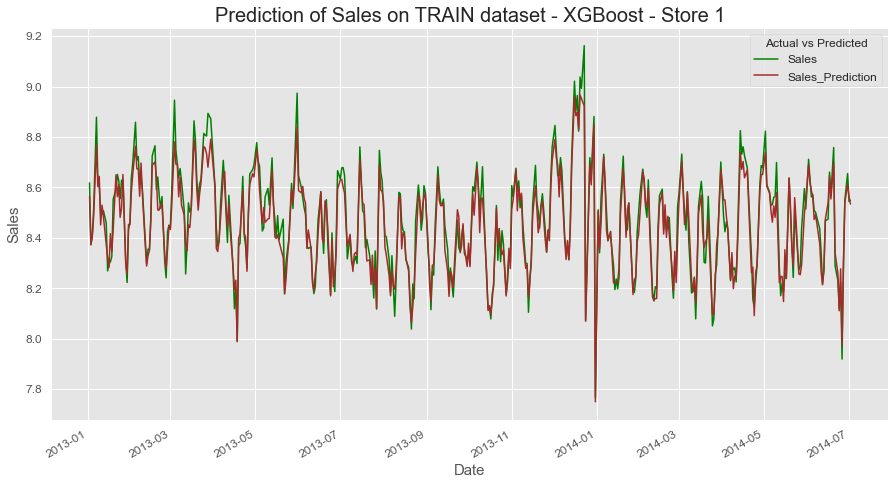

In [388]:
#Plot results actuval vs predicted on train dataset
XGBoost_model_building(1, "train_forecast")[["Sales", "Sales_Prediction"]].plot(figsize=(15, 8),
                                                                                        style=['-','-'],
                                                                                        color=["green", "brown"])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Sales",fontsize=15)
plt.title("Prediction of Sales on TRAIN dataset - XGBoost - Store 1", fontsize=20)
plt.legend(loc="best",
           prop={"size": 12},
           title="Actual vs Predicted",
           title_fontsize="12",
           frameon=True)
plt.savefig("XGBoost_results/Store_1_forecast/Forecast_plot_TRAIN_XGB.png", bbox_inches = "tight")
plt.show()

In [389]:
#Forecast on test dataset
XGBoost_model_building(1, "test_forecast").to_excel("XGBoost_results/Store_1_forecast/test_forecast.xlsx")
XGBoost_model_building(1, "test_forecast")

,Store,Sales,Sales_Prediction
Date,,,
2014-07-03,1,8.467,8.534
2014-07-04,1,8.300,8.573
2014-07-05,1,8.552,8.587
2014-07-07,1,8.348,8.366
2014-07-08,1,8.314,8.330
...,...,...,...
2015-07-27,1,8.716,8.680
2015-07-28,1,8.519,8.548
2015-07-29,1,8.473,8.593


In [390]:
#Evaluation of results on test dataset
XGBoost_model_building(1, "evaluation_TEST")

,RMSE_test_XGB,MSE_test_XGB,MAPE_test_XGB,MAE_test_XGB
Store,,,,
1,0.103,0.011,0.956,0.080


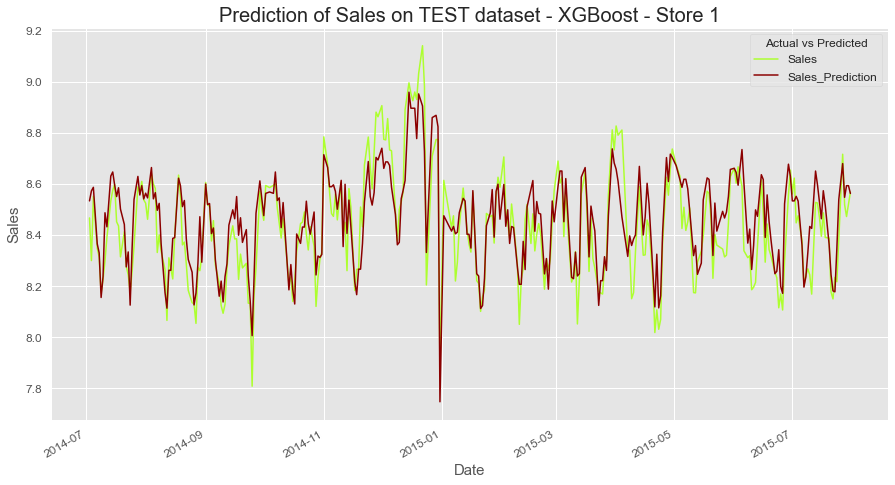

In [391]:
#Plot of actual vs predicted values trom test dataset
XGBoost_model_building(1, "test_forecast")[["Sales", "Sales_Prediction"]].plot(figsize=(15, 8),
                                                                                        style=['-','-'],
                                                                                        color=["greenyellow", "darkred"])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Date",fontsize=15)
plt.ylabel("Sales",fontsize=15)
plt.title("Prediction of Sales on TEST dataset - XGBoost - Store 1", fontsize=20)
plt.legend(loc="best",
           prop={"size": 12},
           title="Actual vs Predicted",
           title_fontsize="12",
           frameon=True)
plt.savefig("XGBoost_results/Store_1_forecast/Forecast_plot_TEST_XGB.png", bbox_inches = "tight")
plt.show()

# 9. Comparision of models

Comparision of ARIMA and XGBoost models was made based on statistic evaluation of forecast created by loop where was made forecast for a few Stores. Generally, XGBoost presents definitely better results than ARIMA in each metrics.

In [421]:
#Comparision of models (ARIMA, XGBoost) based on statistic of forecast evaluation of a few Stores by loops
#(not function) ARIMA and XGB
models_comparision = pd.merge(comparision_evaluation_loop_arima[["MAE_test_ARIMA",
                                                                  "MAPE_test_ARIMA",
                                                                  "MSE_test_ARIMA",
                                                                  "RMSE_test_ARIMA"]], #statistic of evaluation of ARIMA model
                              comparision_evaluation_loop_xgb[["MAE_test_XGB",
                                                               "MAPE_test_XGB",
                                                               "MSE_test_XGB",
                                                               "RMSE_test_XGB"]], #statistic of evaluation of XGBoost model
                              left_index = True,
                              right_index = True)
#Order of columns
models_comparision = models_comparision[["MAE_test_ARIMA", "MAE_test_XGB",
                                         "MAPE_test_ARIMA", "MAPE_test_XGB",
                                         "MSE_test_ARIMA", "MSE_test_XGB",
                                         "RMSE_test_ARIMA", "RMSE_test_XGB"]]
models_comparision.to_excel("Comparision_of_ARIMA_XGB_metrics.xlsx")
models_comparision

,MAE_test_ARIMA,MAE_test_XGB,MAPE_test_ARIMA,MAPE_test_XGB,MSE_test_ARIMA,MSE_test_XGB,RMSE_test_ARIMA,RMSE_test_XGB
Store,,,,,,,,
494,0.222,0.067,2.483,0.751,0.077,0.008,0.277,0.091
85,0.206,0.073,2.294,0.825,0.076,0.010,0.275,0.098
1,0.240,0.080,2.857,0.956,0.091,0.011,0.302,0.103
423,0.162,0.080,1.746,0.870,0.044,0.016,0.210,0.127
682,0.241,0.059,2.614,0.643,0.084,0.007,0.290,0.084
561,0.205,0.069,2.326,0.780,0.061,0.009,0.246,0.097
353,0.300,0.085,3.399,0.977,0.130,0.013,0.361,0.114
274,0.279,0.099,3.256,1.176,0.148,0.017,0.385,0.130


# 10. Conclusions

**General summary**

The main target of this project was to build, evaluate and compare ARIMA and XGBoost models to make a forcast of sales in Stores from dataset. Input dataset contains 1 017 209 observations as well as 18 variables included target variable (Sales).<br>
    
It is essential to remember that to make good forecast it is important to have enought observations for each Store, in this project was made forecast (using ARIMA and XGBoost) in loop for 10 sample stores (to make comparision fo models) and for 1 store in dedicated build function. Of course it is possible to run function (to make forecast for one Store in one time) or loop (to make forecast for list of Stores in one time) on the whole dataset, but in can consume a lot of time and each Store can be represented by enought observations to make good forcast for this Store. <br>

In some Stores could be not enought observations to make good prediction, and in this case could be overfitting and if some store does not have enought observation, foracast of sales could be even impossible. In this situation is recommended to increase the number of observations for stores that have few observations.<br>

**EDA (Exploratory Data Analysis) summary**

In EDA was performed a lot of modifications to prepare dataset to modelling: calculation fo enumerative variables, calculation of days untill and afted holiday, checking data types, duplicates, missings, outliers by boxplots and Isolation Forest, checking distribution of target variable and also logarithm target variable, time series analysis by plots, visualization of seasonality as well as trend per StoreType, dummy coding of categorical varaibles and analysis of CORR by Pearson and Spearman coefficient. <br>

**Modelling summary**

Data selection was performed only based on Spearman CORR, because its does not need normal distribution of variables.<br>

ARIMA<br>
Firstly was created ARIMA model where at the begining were generated ACF and PACF plots. Then was performed Augmented Dickey-Fuller Test to check stationary of series. After that tunning of hiper parameters was made by using loop, where the best (the lowest) AIC and BIC has configuration of order parameters in ARIMA model = 0, 1, 1 and finally this configuraion was used in ARIMA model, because auto_arima consume to much time and finally was not performed (only code was written as comment).<br>

For ARIMA was performed function (to make forecast for one Store in one time) and loop (to make forecast for list of Stores in one time). Evaluaton of model was performed based on: MAE, MSE, RMSE, MAPE. Forecast was save as DF and plots with results on train adn test dataset.<br>

XGBoost<br>
In terms of XGBoost variables: next_holida_date and last_holida_date was removed beause there already exists variables present number of days till and after holiday. <br>

For XGBoost also was performed function (to make forecast for one Store in one time) and loop (to make forecast for list of Stores in one time). Evaluaton of model was performed based on: MAE, MSE, RMSE, MAPE. Forecast was save as DF and plots with results on train adn test dataset.<br>

Generally, results on train and test dataset are similar on ARIMA and XGBoost, so probably there is no overfitting. But is some Stores could be not enought observations to make good prediction, and it this case bould be overfitting and if some store does not have enought observation, foracast of sales could be even impossible.<br>

Comparision of models also was made based on: MAE, MSE, RMSE, MAPE.